<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [18]:
#For use during testing:
#!pip install leidenalg
#!pip install --index-url https://test.pypi.org/simple/ modisco

!pip install modisco

In [1]:
from __future__ import print_function, division
%matplotlib inline
/
try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
import os

## Grab the input data

In [21]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [3]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
import h5py
from collections import OrderedDict
import numpy as np

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = len(fasta_sequences) #100 #since this is just a test run, for speed I am limiting to 100 sequences
#reverse-complement some of the sequences to simulate that
take_rc = (np.random.RandomState(1234).uniform(size=n) > 0.5)
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                            for x,rc in zip(f['contrib_scores'][task][:n], take_rc)]
    task_to_hyp_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                                for x,rc in zip(f['hyp_contrib_scores'][task][:n], take_rc)]

onehot_data = [one_hot_encode_along_channel_axis(seq) if not rc else
               one_hot_encode_along_channel_axis(seq)[::-1,::-1]
               for seq,rc in zip(fasta_sequences[:n], take_rc)]

Double check by plotting

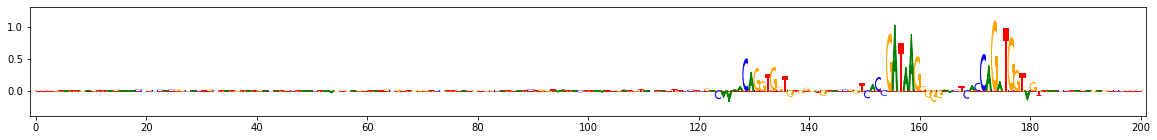

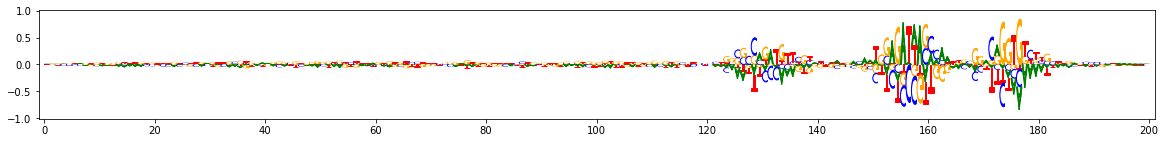

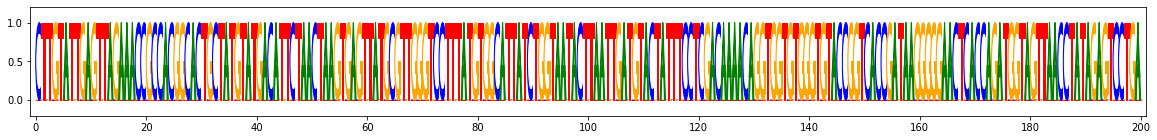

In [24]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. If all three tasks are specified under "task_names", then there will be 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). If only task0 is specified, there will only be two possible metaclusters (+1 and -1). In recent years, we have moved towards running tfmodisco on a single task at a time, which is why the example below just uses task0 (which turns up both the TAL and GATA motifs).

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by initial_flank_to_add. This is set to 3 rather than the default of 10.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 1.376534528
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02423818802833557
Computing threshold
For increasing = True , the minimum IR precision was 0.39972449540266214 occurring at 9.5367431640625e-07 implying a frac_neg of 0.6659017273589992
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.19755100216745247 occurring at -4.76837158203125e-06 implying a frac_neg of 0.24618511918021832
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.9881415814161301  and  0.8861856460571289 with frac passing 0.1614784946236559
Final raw thresholds are -0.9881415814161301  and  0.8861856460571289
Final transformed thresholds are -0.8458602150537634  and  0.8379905913978495


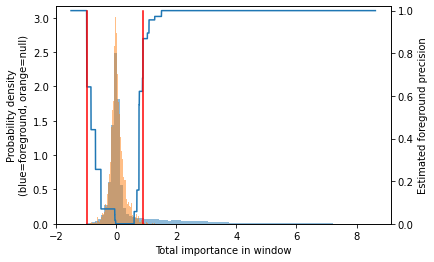

Got 1598 coords
After resolving overlaps, got 1598 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8378905913978495
MEMORY 1.3766656
1598 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [1576]
Idx to activities:  {0: '1'}
MEMORY 1.376681984
On metacluster 0
Metacluster size 1576
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 1576
(Round 1) Computing coarse affmat
MEMORY 1.376681984
Beginning embedding computation
MEMORY 1.376681984


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   16.9s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   26.9s
[Parallel(n_jobs=10)]: Done 1576 out of 1576 | elapsed:   34.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:   15.4s
[Parallel(n_jobs=10)]: Done 1540 tasks      | elapsed:   29.2s
[Parallel(n_jobs=10)]: Done 1557 out of 1576 | elapsed:   29.6s remaining:    0.4s
[Parallel(n_jobs=10)]: Done 1576 out of 1576 | elapsed:   29.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend wit

Constructing csr matrix...
csr matrix made in 0.41091275215148926 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1576 out of 1576 | elapsed:    3.8s finished


Constructing csr matrix...
csr matrix made in 0.37528085708618164 s
Finished embedding computation in 73.45 s
MEMORY 1.438900224
Starting affinity matrix computations
MEMORY 1.438900224
Batching in slices of size 1576


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

Finished affinity matrix computations in 2.4 s
MEMORY 1.447432192
(Round 1) Computed coarse affmat
MEMORY 1.447432192
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 1.447432192


Launching nearest neighbors affmat calculation job
MEMORY 1.447432192
Parallel runs completed
MEMORY 1.448255488
Job completed in: 13.48 s
MEMORY 1.448255488
Launching nearest neighbors affmat calculation job
MEMORY 1.448255488
Parallel runs completed
MEMORY 1.449807872
Job completed in: 13.66 s
MEMORY 1.44975872
(Round 1) Computed affinity matrix on nearest neighbors in 27.63 s
MEMORY 1.451626496
Filtered down to 1491 of 1576
(Round 1) Retained 1491 rows out of 1576 after filtering
MEMORY 1.451626496
(Round 1) Computing density adapted affmat
MEMORY 1.451626496
[t-SNE] Computed conditional probabilities for sample 1000 / 1491
[t-SNE] Computed conditional probabilities for sample 1491 / 1491
[t-SNE] Mean sigma: 0.190438
(Round 1) Computing clustering
MEMORY 1.452658688
Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.1s


Quality: 0.6363277155767024
Quality: 0.6370246415571763
Got 10 clusters after round 1
Counts:
{0: 293, 4: 151, 2: 265, 6: 68, 8: 26, 1: 266, 9: 6, 3: 224, 7: 48, 5: 144}
MEMORY 1.452658688
(Round 1) Aggregating seqlets in each cluster
MEMORY 1.452658688
Aggregating for cluster 0 with 293 seqlets
MEMORY 1.452658688
Skipped 1 seqlets that went over the sequence edge during flank expansion


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    6.2s finished


Skipped 44 seqlets that went over sequence edge during flank expansion
Skipped 6 due to duplicates
Trimming eliminated 0 seqlets out of 242
Skipped 24 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 266 seqlets
MEMORY 1.452658688
Skipped 2 seqlets that went over the sequence edge during flank expansion
Skipped 2 seqlets that went over the sequence edge during flank expansion
Skipped 33 seqlets that went over sequence edge during flank expansion
Skipped 5 due to duplicates
Trimming eliminated 0 seqlets out of 224
Skipped 15 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 265 seqlets
MEMORY 1.452720128
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 28 seqlets that went over sequence edge during flank expansion
Skipped 7 due to duplicates
Trimming eliminated 0 seqlets out of 228
Skipped 17

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:   15.1s
[Parallel(n_jobs=10)]: Done 1160 out of 1179 | elapsed:   20.8s remaining:    0.3s
[Parallel(n_jobs=10)]: Done 1179 out of 1179 | elapsed:   21.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:   15.2s
[Parallel(n_jobs=10)]: Done 1160 out of 1179 | elapsed:   21.1s remaining:    0.3s
[Parallel(n_jobs=10)]: Done 1179 out of 1179 | elapsed:   21.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1179 out of 1179 | elapsed:    2.9s finished


Constructing csr matrix...
csr matrix made in 0.3000979423522949 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1179 out of 1179 | elapsed:    2.9s finished


Constructing csr matrix...
csr matrix made in 0.27061986923217773 s
Finished embedding computation in 49.52 s
MEMORY 1.449250816
Starting affinity matrix computations
MEMORY 1.449250816
Batching in slices of size 1179


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

Finished affinity matrix computations in 2.15 s
MEMORY 1.449250816
(Round 2) Computed coarse affmat
MEMORY 1.449250816
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 1.449250816


Launching nearest neighbors affmat calculation job
MEMORY 1.449271296
Parallel runs completed
MEMORY 1.449418752
Job completed in: 9.97 s
MEMORY 1.449271296
Launching nearest neighbors affmat calculation job
MEMORY 1.449271296
Parallel runs completed
MEMORY 1.449345024
Job completed in: 9.98 s
MEMORY 1.449271296
(Round 2) Computed affinity matrix on nearest neighbors in 20.35 s
MEMORY 1.449271296
Not applying filtering for rounds above first round
MEMORY 1.449271296
(Round 2) Computing density adapted affmat
MEMORY 1.449271296
[t-SNE] Computed conditional probabilities for sample 1000 / 1179
[t-SNE] Computed conditional probabilities for sample 1179 / 1179
[t-SNE] Mean sigma: 0.191930
(Round 2) Computing clustering
MEMORY 1.449730048
Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.4s


Quality: 0.631114066340768
Quality: 0.632789939834382
Quality: 0.633282748284821
Got 9 clusters after round 2
Counts:
{0: 230, 2: 212, 5: 124, 6: 60, 3: 169, 1: 223, 4: 157, 8: 2, 7: 2}
MEMORY 1.449730048
(Round 2) Aggregating seqlets in each cluster
MEMORY 1.449730048
Aggregating for cluster 0 with 230 seqlets
MEMORY 1.449730048


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    5.3s finished


Skipped 9 due to duplicates
Trimming eliminated 0 seqlets out of 221
Aggregating for cluster 1 with 223 seqlets
MEMORY 1.450151936
Skipped 7 due to duplicates
Trimming eliminated 0 seqlets out of 216
Aggregating for cluster 2 with 212 seqlets
MEMORY 1.45065984
Trimming eliminated 0 seqlets out of 212
Aggregating for cluster 3 with 169 seqlets
MEMORY 1.45094656
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 168
Aggregating for cluster 4 with 157 seqlets
MEMORY 1.451081728
Skipped 3 due to duplicates
Trimming eliminated 0 seqlets out of 154
Aggregating for cluster 5 with 124 seqlets
MEMORY 1.45117184
Skipped 2 due to duplicates
Trimming eliminated 0 seqlets out of 122
Aggregating for cluster 6 with 60 seqlets
MEMORY 1.451184128
Skipped 5 due to duplicates
Trimming eliminated 0 seqlets out of 55
Skipped 1 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 7 with 2 seqlets
MEMORY 1.451200512
Skipped 1 due to duplicates
Trimming elimina

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 221 out of 221 | elapsed:    0.1s finished


Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.3s


Quality: 0.2559535451818694
Quality: 0.25702021422468985
Quality: 0.25739732078597855
Quality: 0.2581347204242826
Quality: 0.25854047765185123
Quality: 0.25896067026061587
Quality: 0.25973191953166985
Got subclusters: Counter({0: 49, 1: 48, 2: 44, 3: 40, 4: 40})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    3.8s finished


Numbers for each pattern pre-subsample: [49, 48, 44, 40, 40]
Numbers after subsampling: [49, 48, 44, 40, 40]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.19217586517333984 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.18296599388122559 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.16325783729553223 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.1528489589691162 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.14745378494262695 s
Cluster sizes
[49 48 44 40 40]
Cross-contamination matrix:
[[1.   0.73 0.78 0.84 0.74]
 [0.75 1.   0.72 0.82 0.78]
 [0.86 0.78 1.   0.88 0.84]
 [0.68 0.65 0.66 1.   0.59]
 [0.82 0.83 0.84 0.81 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.97 0.98 0.99 0.97]
 [0.97 1.   0.95 0.97 0.99]
 [0.98 0.95 1.   0.98 0.96]
 [0.99 0.97 0.98 1.   0.97]
 [0.97 0.99 0.96 0.97 1.  ]]
Collapsing 0 & 3 with crosscontam 0.6841734693877553 and sim 0.9875248758002717
Collapsing 1 & 4 with crosscon

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 216 out of 216 | elapsed:    0.1s finished


Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.2s


Quality: 0.28999289662834593
Quality: 0.2901558703271751
Quality: 0.29025568581457867
Quality: 0.29100448939935714
Got subclusters: Counter({0: 64, 1: 54, 2: 50, 3: 38, 4: 10})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    3.6s finished


Numbers for each pattern pre-subsample: [64, 54, 50, 38, 10]
Numbers after subsampling: [64, 54, 50, 38, 10]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.21499991416931152 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.202009916305542 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.1895749568939209 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.16116905212402344 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.07216477394104004 s
Cluster sizes
[64 54 50 38 10]
Cross-contamination matrix:
[[1.   0.97 0.65 0.75 0.69]
 [0.47 1.   0.53 0.55 0.51]
 [0.46 0.87 1.   0.55 0.46]
 [0.6  0.91 0.58 1.   0.62]
 [0.67 0.86 0.61 0.7  1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.97 0.94 0.94 0.95]
 [0.97 1.   0.94 0.96 0.93]
 [0.94 0.94 1.   0.93 0.91]
 [0.94 0.96 0.93 1.   0.92]
 [0.95 0.93 0.91 0.92 1.  ]]
Collapsing 0 & 1 with crosscontam 0.4715077732053039 and sim 0.9696953717902241
Collapsing 1 & 3 with crossconta

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 212 out of 212 | elapsed:    0.1s finished


Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.2s


Quality: 0.25025450445342773
Quality: 0.25345127977046394
Quality: 0.2536957270018613
Quality: 0.2542778279371092
Got subclusters: Counter({0: 49, 1: 39, 2: 36, 3: 31, 4: 27, 5: 20, 6: 10})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    3.7s finished


Numbers for each pattern pre-subsample: [49, 39, 36, 31, 27, 20, 10]
Numbers after subsampling: [49, 39, 36, 31, 27, 20, 10]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.25979185104370117 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.23572230339050293 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.22215509414672852 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.1890580654144287 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.17319774627685547 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.13659024238586426 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.08849811553955078 s
Cluster sizes
[49 39 36 31 27 20 10]
Cross-contamination matrix:
[[1.   0.53 0.72 0.8  0.82 0.34 0.69]
 [0.89 1.   0.88 0.88 0.89 0.54 0.85]
 [0.66 0.48 1.   0.78 0.79 0.28 0.47]
 [0.73 0.53 0.77 1.   0.83 0.42 0.66]
 [0.64 0.39 0.67 0.73 1.   0.21 0.47]
 [0.94 0.81 0.92 0.98 0.97 1.   0.91]
 [0.55 0.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 168 out of 168 | elapsed:    0.1s finished


Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.1s


Quality: 0.23413512713792653
Quality: 0.23511128349079735
Quality: 0.2351826612647179
Quality: 0.2352571623814457
Got subclusters: Counter({0: 49, 1: 46, 2: 43, 3: 30})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    3.3s finished


Numbers for each pattern pre-subsample: [49, 46, 43, 30]
Numbers after subsampling: [49, 46, 43, 30]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.14475083351135254 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.13261103630065918 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.12131500244140625 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.1065521240234375 s
Cluster sizes
[49 46 43 30]
Cross-contamination matrix:
[[1.   0.79 0.85 1.  ]
 [0.78 1.   0.84 0.89]
 [0.73 0.74 1.   0.93]
 [0.65 0.52 0.66 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.99 0.98 0.99]
 [0.99 1.   0.99 0.98]
 [0.98 0.99 1.   0.98]
 [0.99 0.98 0.98 1.  ]]
Collapsing 1 & 2 with crosscontam 0.7352636710686125 and sim 0.9878396797250115
Collapsing 0 & 1 with crosscontam 0.7779213764901045 and sim 0.9877556585252807
Collapsing 0 & 3 with crosscontam 0.6513529856386999 and sim 0.9870436734222796
Collapsing 0 & 2 with crosscontam 0.7314124311477643 and si

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 154 out of 154 | elapsed:    0.1s finished


Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.0s


Quality: 0.22398851952997606
Quality: 0.22437360092990385
Quality: 0.22603774801789522
Quality: 0.2264338315173059
Quality: 0.22664036150811698
Quality: 0.22669770987462293
Quality: 0.2267733265405908
Quality: 0.22700567110497594
Got subclusters: Counter({0: 40, 1: 33, 2: 31, 3: 23, 4: 21, 5: 4, 6: 2})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    3.3s finished


Numbers for each pattern pre-subsample: [40, 33, 31, 23, 21, 4, 2]
Numbers after subsampling: [40, 33, 31, 23, 21, 4, 2]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.20395112037658691 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.2006089687347412 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.1830751895904541 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.14333796501159668 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.13308215141296387 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.053915977478027344 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.04399991035461426 s
Cluster sizes
[40 33 31 23 21  4  2]
Cross-contamination matrix:
[[1.   0.85 0.69 0.8  0.55 0.25 0.27]
 [0.59 1.   0.72 0.7  0.44 0.3  0.2 ]
 [0.67 0.88 1.   0.81 0.48 0.48 0.38]
 [0.72 0.87 0.79 1.   0.5  0.31 0.31]
 [0.89 0.96 0.75 0.85 1.   0.41 0.33]
 [0.   0.02 0.03 0.   0.   1.   0.  ]
 [0.   0.   0

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 122 out of 122 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.0s


Quality: 0.20038151563709442
Quality: 0.20079454019285936
Quality: 0.2008076120155035
Quality: 0.20186085446064111
Got subclusters: Counter({0: 35, 1: 32, 2: 27, 3: 20, 4: 8})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    3.2s finished


Numbers for each pattern pre-subsample: [35, 32, 27, 20, 8]
Numbers after subsampling: [35, 32, 27, 20, 8]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.14417529106140137 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.12848901748657227 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.10611724853515625 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.0840311050415039 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.05218696594238281 s
Cluster sizes
[35 32 27 20  8]
Cross-contamination matrix:
[[1.   0.63 0.86 0.53 0.57]
 [0.86 1.   0.95 0.75 0.76]
 [0.66 0.54 1.   0.39 0.41]
 [0.91 0.81 0.96 1.   0.68]
 [0.58 0.5  0.65 0.34 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.96 0.97 0.96 0.95]
 [0.96 1.   0.96 0.97 0.94]
 [0.97 0.96 1.   0.96 0.96]
 [0.96 0.97 0.96 1.   0.94]
 [0.95 0.94 0.96 0.94 1.  ]]
Collapsing 1 & 3 with crosscontam 0.747540283203125 and sim 0.9734229005655683
Collapsing 0 & 2 with crosscontam

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 550 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 607 out of 607 | elapsed:    0.7s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 607 samples in 0.006s...
[t-SNE] Computed neighbors for 607 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 607 / 607
[t-SNE] Mean sigma: 0.256214
[t-SNE] Computed conditional probabilities in 0.034s
[t-SNE] Iteration 50: error = 74.6279602, gradient norm = 0.3779908 (50 iterations in 0.100s)
[t-SNE] Iteration 100: error = 77.3262253, gradient norm = 0.3522919 (50 iterations in 0.101s)
[t-SNE] Iteration 150: error = 75.0139313, gradient norm = 0.3741014 (50 iterations in 0.095s)
[t-SNE] Iteration 200: error = 74.9416962, gradient norm = 0.3736030 (50 iterations in 0.100s)
[t-SNE] Iteration 250: error = 78.5913315, gradient norm = 0.3287796 (50 iterations in 0.101s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.591331
[t-SNE] Iteration 300: error = 1.4898289, gradient norm = 0.0044407 (50 iterations in 0.084s)
[t-SNE] Iteration 350: error = 1.3848932, gradient norm = 0.0013111 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.6s


Quality: 0.3947479478769087
Quality: 0.39574528259470926
Quality: 0.39625468636681943
Quality: 0.39627553591743503
Quality: 0.3965546035594031


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.1s


Got subclusters: Counter({0: 166, 1: 163, 2: 120, 3: 52, 4: 37, 5: 28, 6: 24, 7: 9, 8: 8})
On pattern 1


[Parallel(n_jobs=10)]: Done 537 out of 537 | elapsed:    0.5s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 537 samples in 0.005s...
[t-SNE] Computed neighbors for 537 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 537 / 537
[t-SNE] Mean sigma: 0.274105
[t-SNE] Computed conditional probabilities in 0.029s
[t-SNE] Iteration 50: error = 71.7052307, gradient norm = 0.4310436 (50 iterations in 0.099s)
[t-SNE] Iteration 100: error = 77.7122498, gradient norm = 0.3601750 (50 iterations in 0.094s)
[t-SNE] Iteration 150: error = 78.1049652, gradient norm = 0.3597988 (50 iterations in 0.094s)
[t-SNE] Iteration 200: error = 76.4069672, gradient norm = 0.3613010 (50 iterations in 0.088s)
[t-SNE] Iteration 250: error = 76.7584381, gradient norm = 0.3854276 (50 iterations in 0.093s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.758438
[t-SNE] Iteration 300: error = 1.5219198, gradient norm = 0.0038510 (50 iterations in 0.081s)
[t-SNE] Iteration 350: error = 1.4348496, gradient norm = 0.0012666 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.6s


Quality: 0.3200932103826639
Quality: 0.32041124889597355
Quality: 0.32116017286362936
Quality: 0.32132963124717656
Got subclusters: Counter({0: 129, 1: 120, 2: 91, 3: 83, 4: 41, 5: 31, 6: 26, 7: 16})


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    6.0s finished


In [59]:
import h5py
import numpy as np
%matplotlib inline
import modisco

#Uncomment to refresh modules for when tweaking code during development:
from importlib import reload
reload(modisco.util)
reload(modisco.aggregator)
reload(modisco.core)
reload(modisco.affinitymat.transformers)
reload(modisco.affinitymat.core)
reload(modisco.affinitymat)
reload(modisco.cluster.core)
reload(modisco.cluster)
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
reload(modisco)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        #    meme_command="meme", base_outdir="meme_out",            
                        #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        final_min_cluster_size=60,
                        n_cores=10)
                )(
                 task_names=["task0"],#, "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores=null_per_pos_scores)

## Save Results

In [60]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


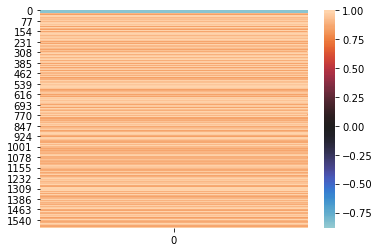

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 607
Task 0 hypothetical scores:


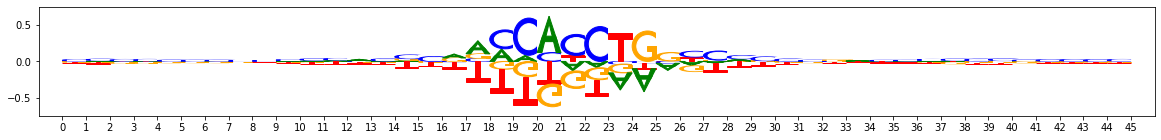

Task 0 actual importance scores:


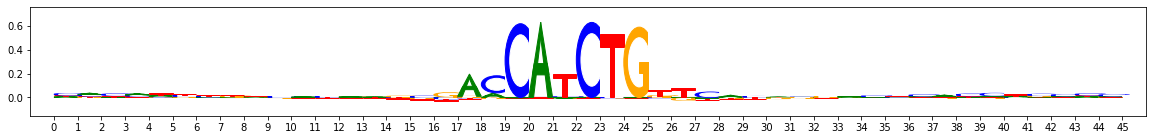

onehot, fwd and rev:


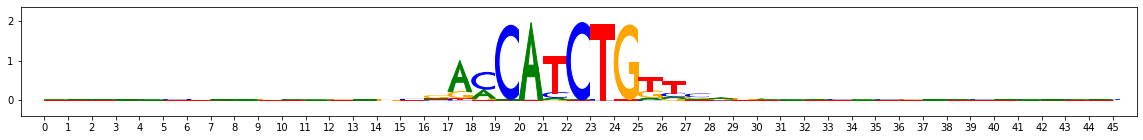

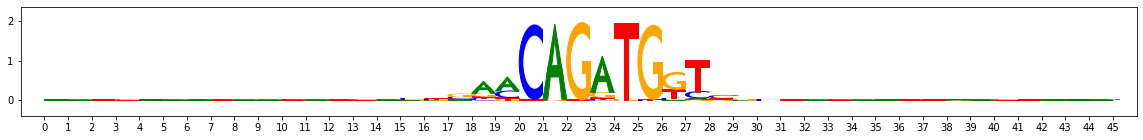

PLOTTING SUBCLUSTERS


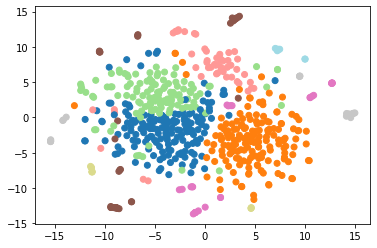

subcluster_0 size 166


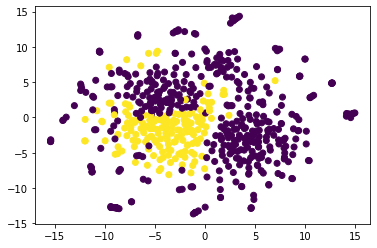

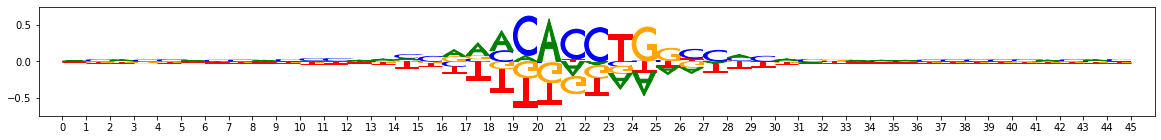

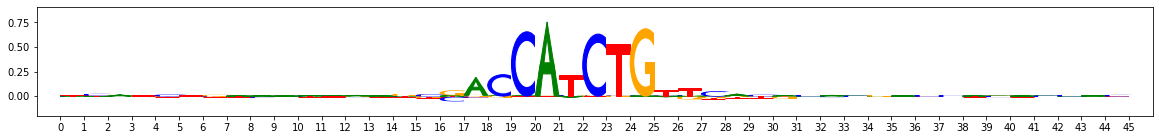

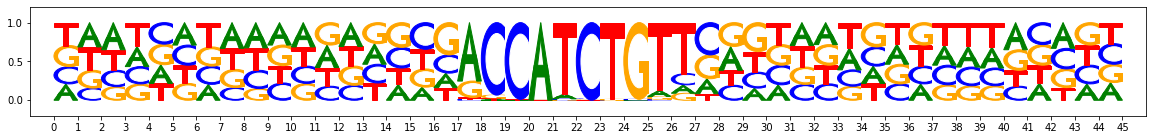

subcluster_1 size 163


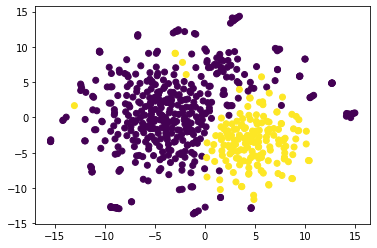

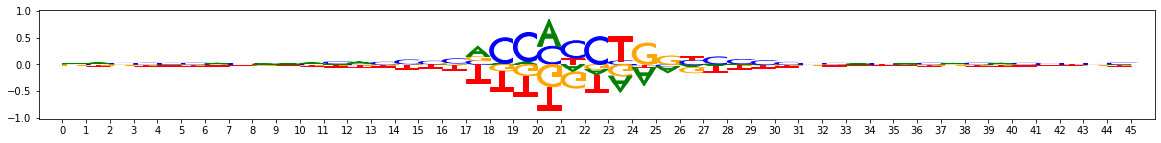

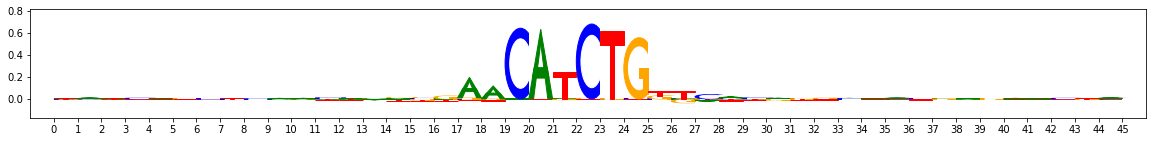

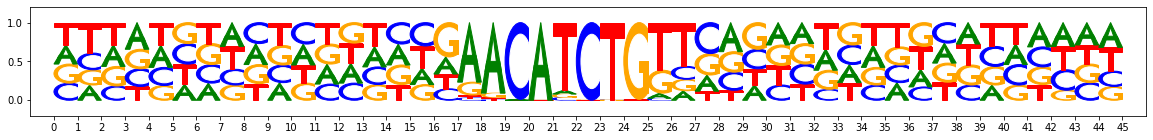

subcluster_2 size 120


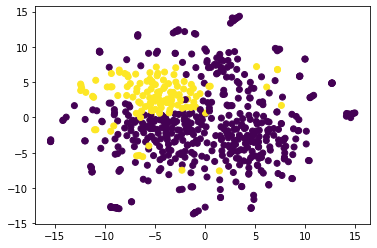

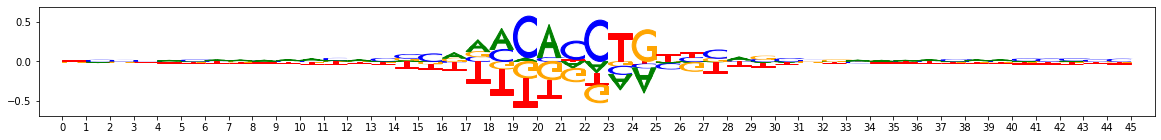

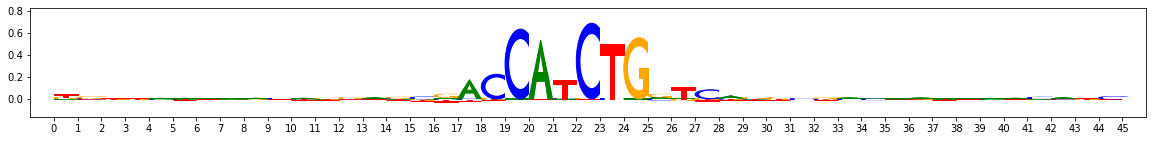

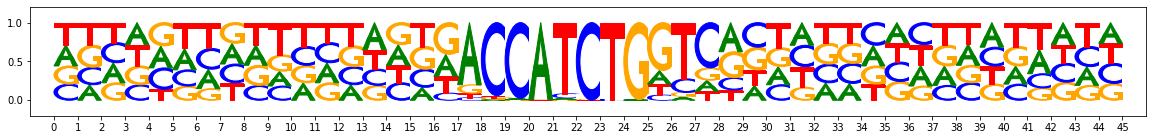

subcluster_3 size 52


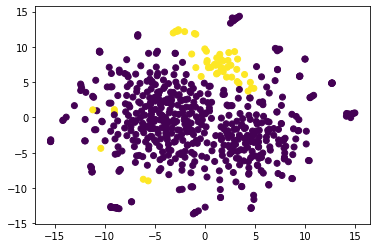

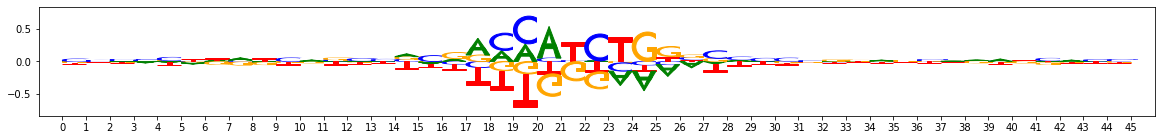

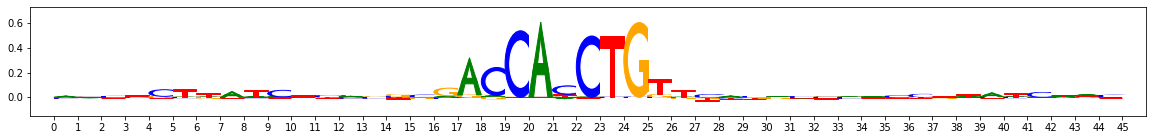

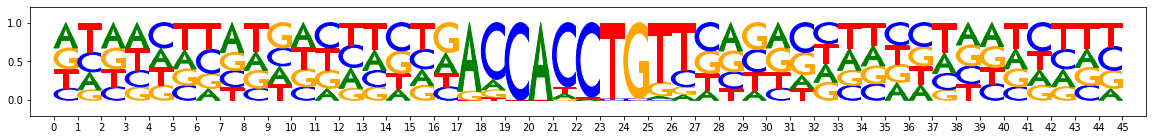

subcluster_4 size 37


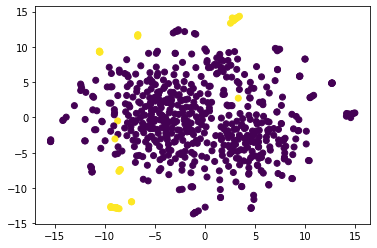

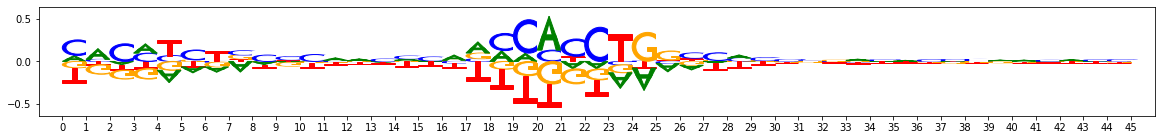

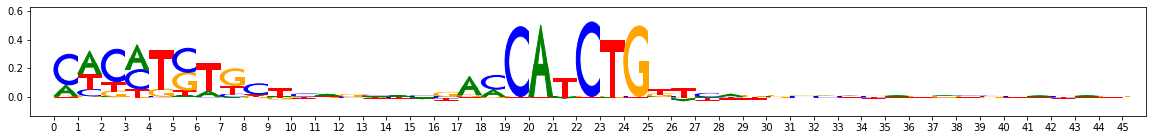

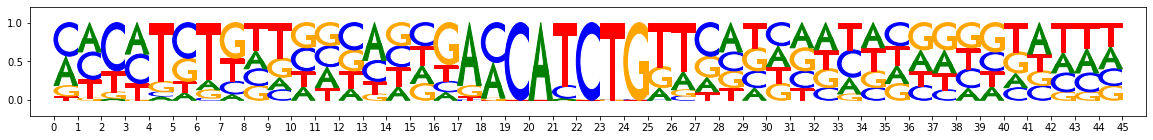

subcluster_5 size 28


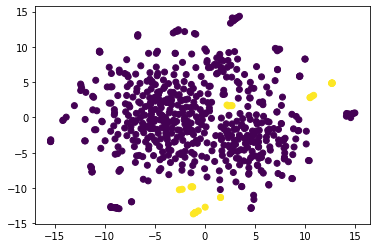

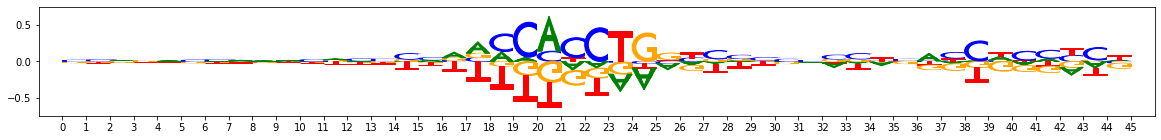

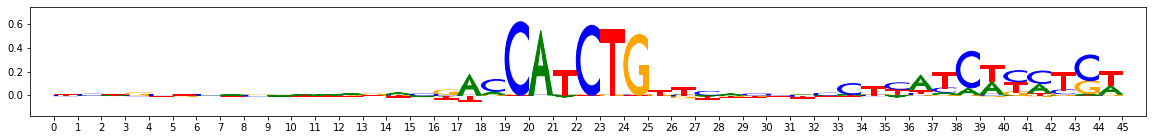

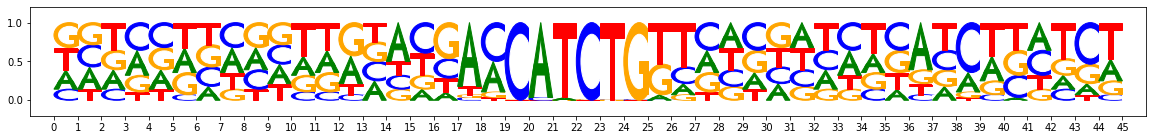

subcluster_6 size 24


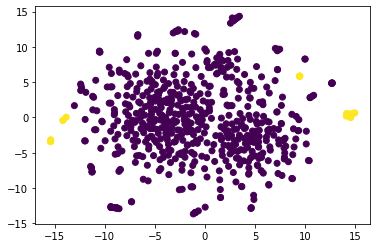

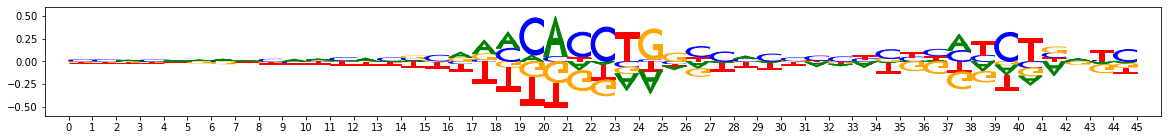

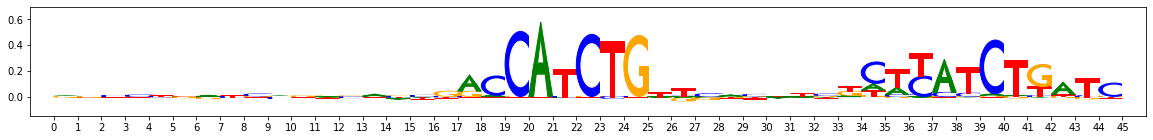

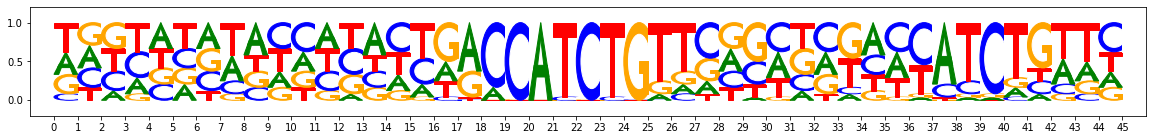

subcluster_7 size 9


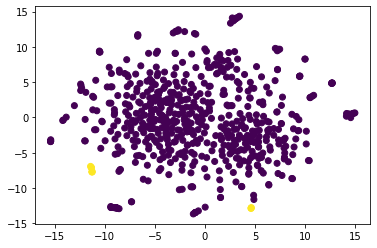

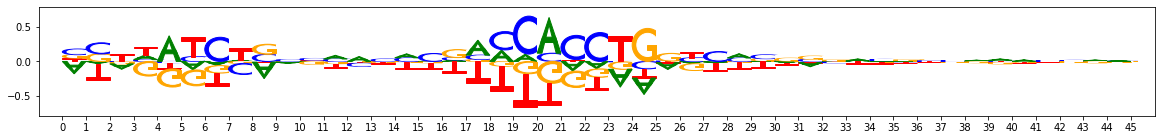

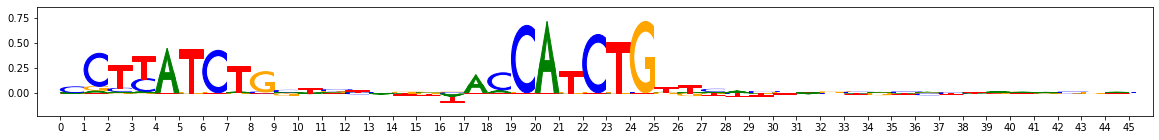

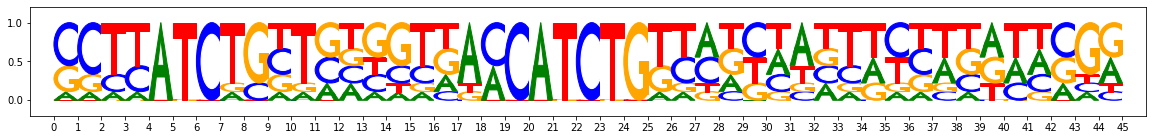

subcluster_8 size 8


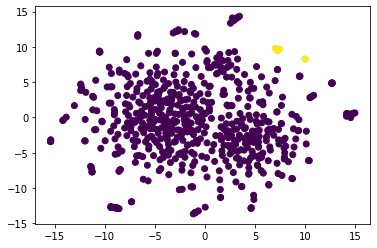

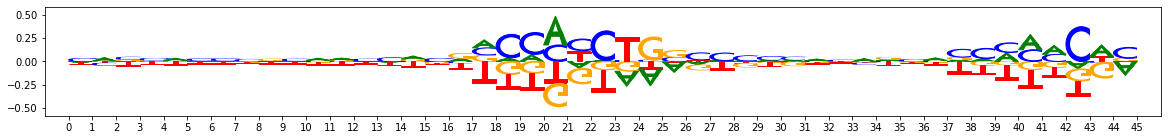

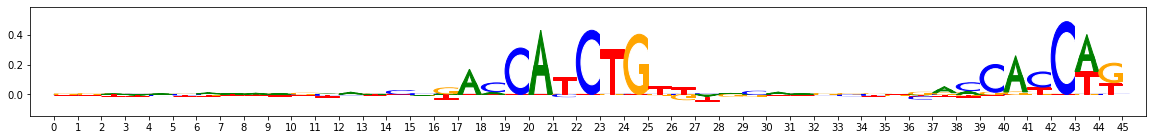

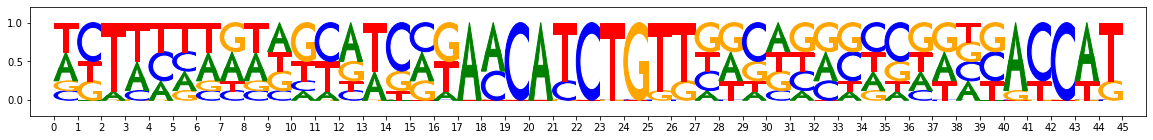

metacluster_0 pattern_1
total seqlets: 537
Task 0 hypothetical scores:


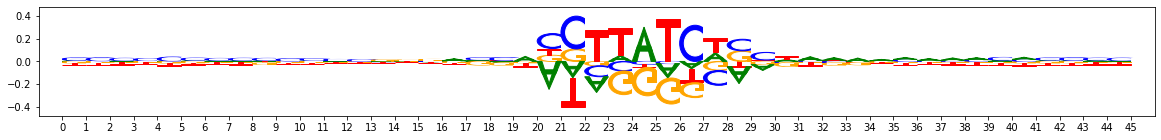

Task 0 actual importance scores:


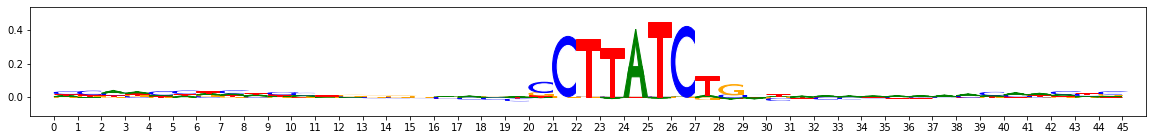

onehot, fwd and rev:


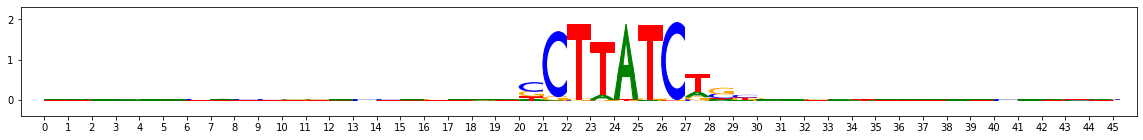

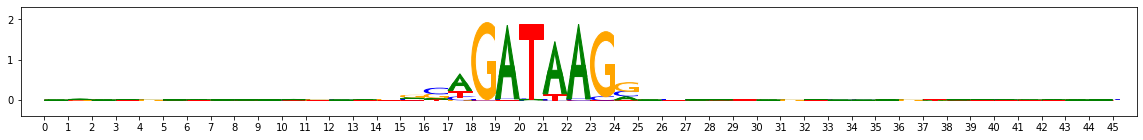

PLOTTING SUBCLUSTERS


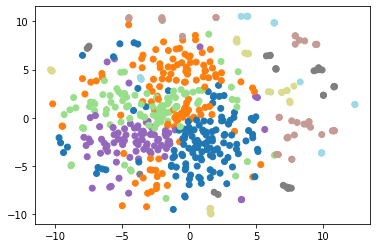

subcluster_0 size 129


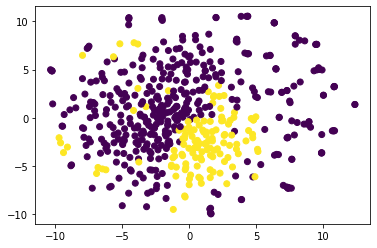

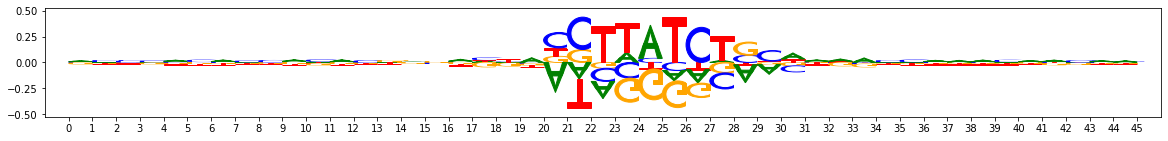

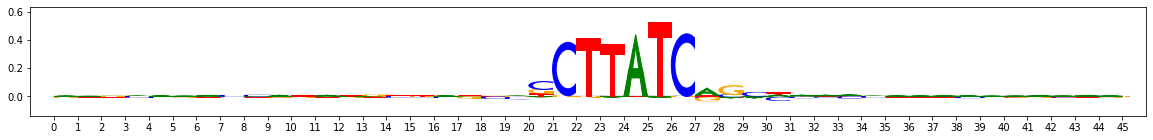

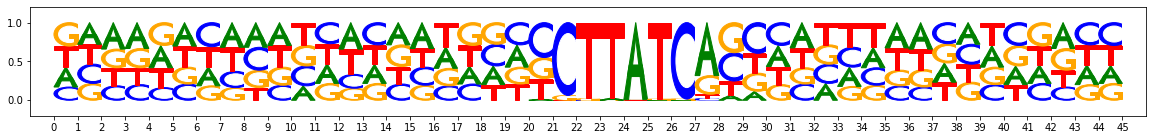

subcluster_1 size 120


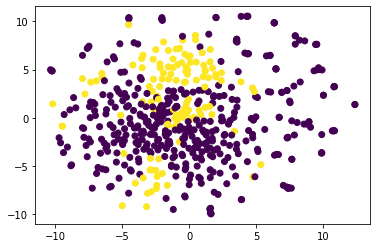

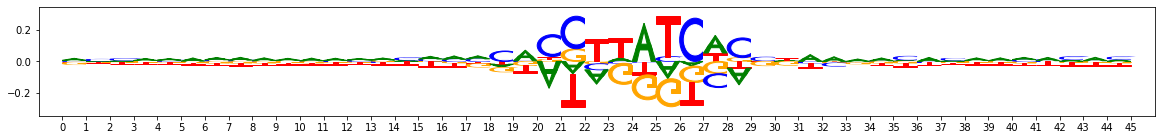

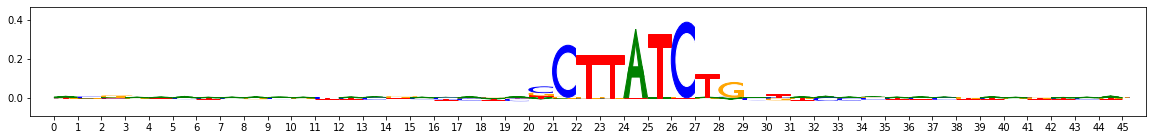

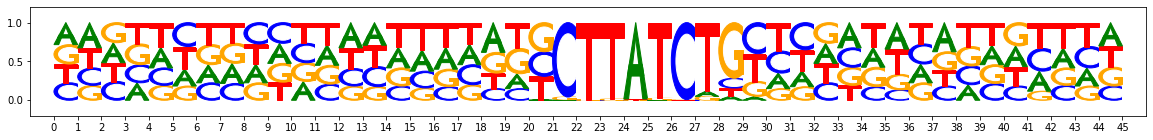

subcluster_2 size 91


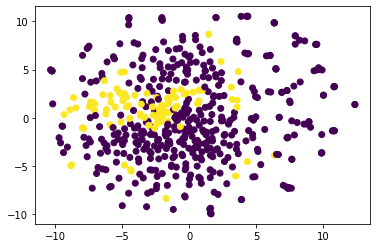

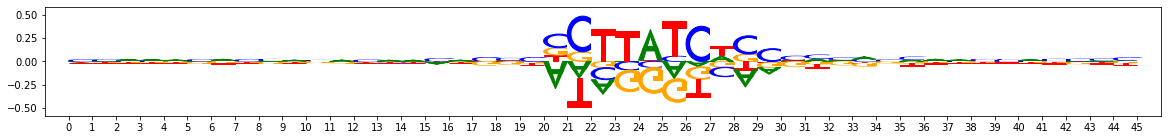

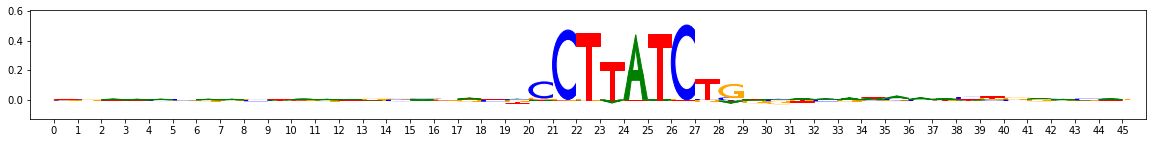

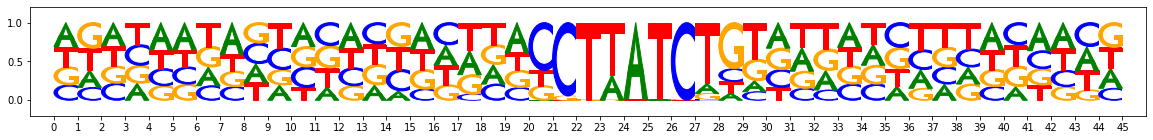

subcluster_3 size 83


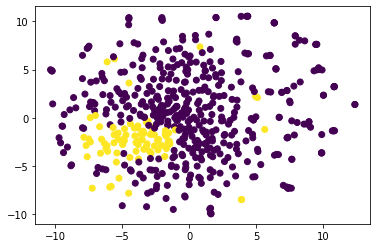

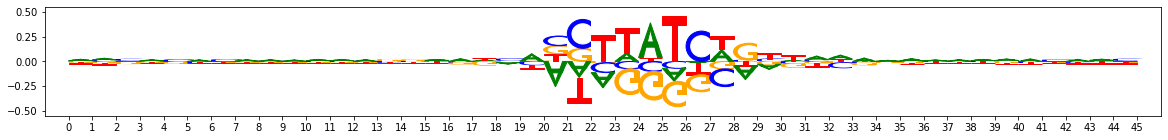

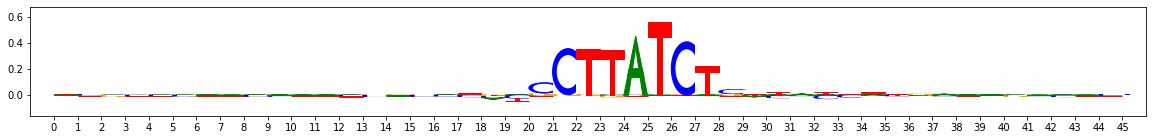

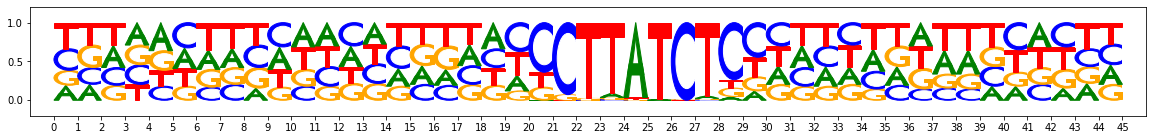

subcluster_4 size 41


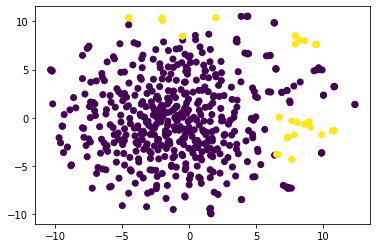

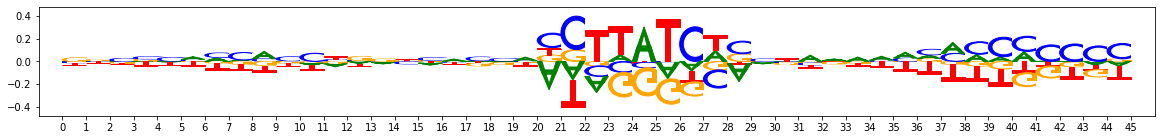

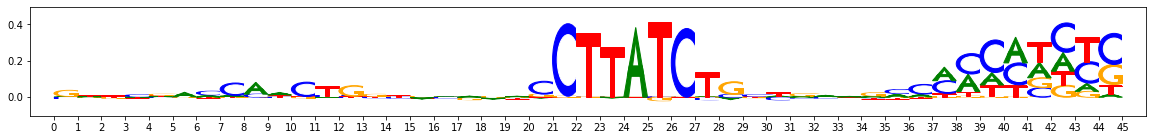

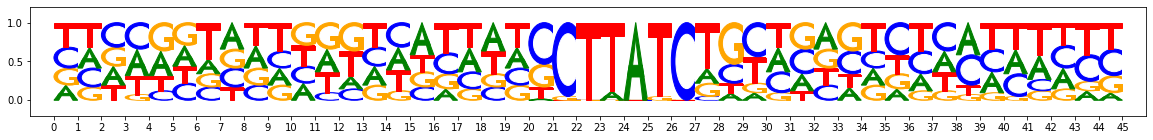

subcluster_5 size 31


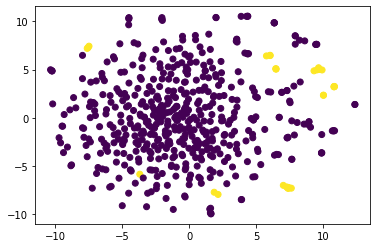

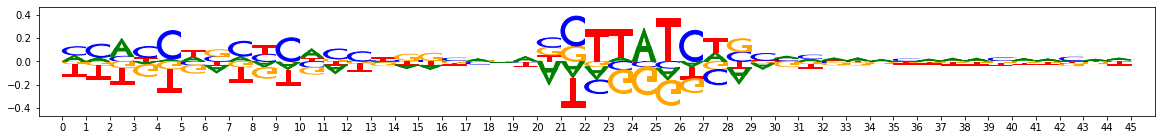

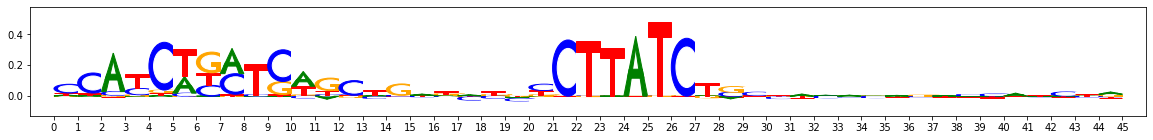

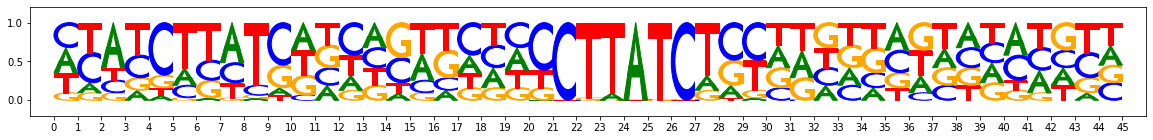

subcluster_6 size 26


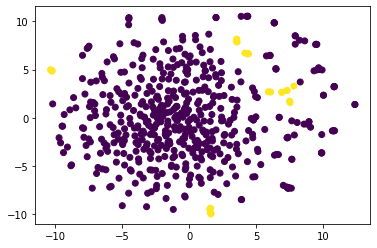

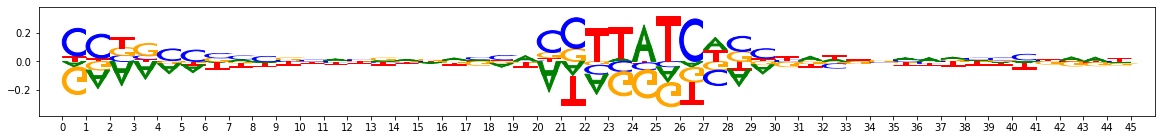

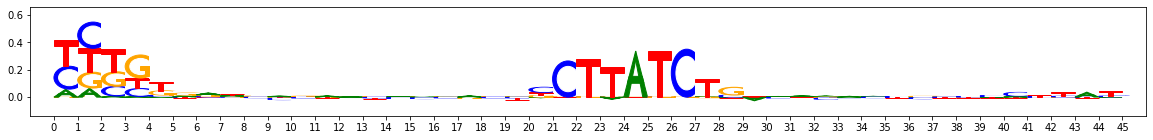

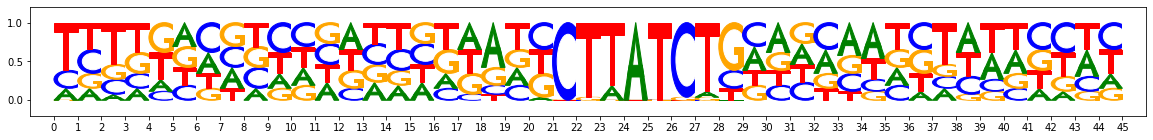

subcluster_7 size 16


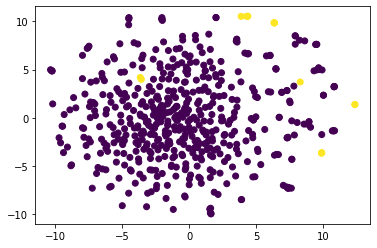

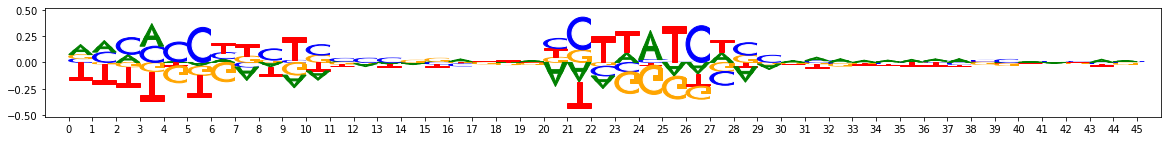

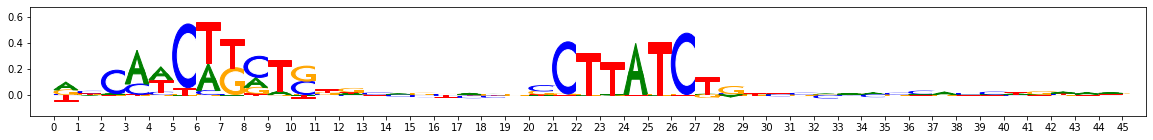

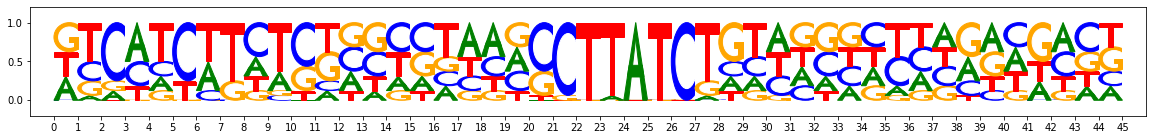

In [61]:
from collections import Counter
import numpy as np

from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.mean(onehot_data, axis=(0,1))

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        #print("Task 1 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        #print("Task 1 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        #print("Task 2 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        #print("Task 2 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        #Plot the subclustering too, if available
        if ("subclusters" in pattern):
            print("PLOTTING SUBCLUSTERS")
            subclusters = np.array(pattern["subclusters"])
            twod_embedding = np.array(pattern["twod_embedding"])
            plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=subclusters, cmap="tab20")
            plt.show()
            for subcluster_name in list(pattern["subcluster_to_subpattern"]["subcluster_names"]):
                subpattern = pattern["subcluster_to_subpattern"][subcluster_name]
                print(subcluster_name.decode("utf-8"), "size", len(subpattern["seqlets_and_alnmts"]["seqlets"]))
                subcluster = int(subcluster_name.decode("utf-8").split("_")[1])
                plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=(subclusters==subcluster))
                plt.show()
                viz_sequence.plot_weights(subpattern["task0_hypothetical_contribs"]["fwd"])
                viz_sequence.plot_weights(subpattern["task0_contrib_scores"]["fwd"])
                viz_sequence.plot_weights(subpattern["sequence"]["fwd"])
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [12]:
import h5py
import numpy as np
from importlib import reload
import modisco
reload(modisco.util)
reload(modisco.core)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

#If loading from a file for which subclusters haven't been computed (e.g. a file produced by an
# earlier version of modisco), you can compute the subclusters by
# following this template:
#patterns = (loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results["metacluster_0"]
#            .seqlets_to_patterns_result.patterns)
#for pattern in patterns:
#    pattern.compute_subclusters_and_embedding(
#                 pattern_comparison_settings=modisco.affinitymat.core.PatternComparisonSettings(                         
#                    track_names=["task0_hypothetical_contribs", "task0_contrib_scores"],                      
#                    track_transformer=modisco.affinitymat.L1Normalizer(),
#                    min_overlap=None), #min_overlap argument is irrelevant here    
#                 perplexity=30, n_jobs=4, verbose=True)

## Do hit scoring
The hit scoring strategy is still in development. For the previous hit scoring strategy, see the version at tag TODO

### Trim the motifs to fixed windows by information content

In [83]:
import modisco
import modisco.util
reload(modisco.util)
reload(modisco.cluster.core)
from modisco.visualization import viz_sequence
reload(modisco.aggregator)
from modisco import hit_scoring
reload(modisco.hit_scoring)
from modisco.hit_scoring import densityadapted_hitscoring
reload(modisco.hit_scoring.densityadapted_hitscoring)
reload(densityadapted_hitscoring)

n_cores = 4
min_overlap_size = 10 #want to have at least this many bp of overlap before scoring
onehot_track_name = "sequence"

target_seqlet_size = 25 #same as during seqlet identification
bg_freq = np.mean(onehot_data, axis=(0,1))

onehot_track_name = "sequence"
task_names = ["task0"]

trimmed_subclustered_patterns = densityadapted_hitscoring.trim_and_subcluster_patterns(
     patterns=orig_patterns,
     window_size=target_seqlet_size,
     onehot_track_name=onehot_track_name,
     task_names=task_names,
     bg_freq=bg_freq,
     n_cores=n_cores)

orig_patterns = (loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_0"]
    .seqlets_to_patterns_result.patterns)

Trimming the patterns to the target length
Apply subclustering


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 600 out of 607 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 607 out of 607 | elapsed:    1.8s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 607 samples in 0.007s...
[t-SNE] Computed neighbors for 607 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 607 / 607
[t-SNE] Mean sigma: 0.242837
[t-SNE] Computed conditional probabilities in 0.036s
[t-SNE] Iteration 50: error = 70.8452148, gradient norm = 0.4087345 (50 iterations in 0.144s)
[t-SNE] Iteration 100: error = 74.5439529, gradient norm = 0.3743009 (50 iterations in 0.153s)
[t-SNE] Iteration 150: error = 76.1525192, gradient norm = 0.3613596 (50 iterations in 0.136s)
[t-SNE] Iteration 200: error = 75.3253021, gradient norm = 0.3908091 (50 iterations in 0.150s)
[t-SNE] Iteration 250: error = 75.9620667, gradient norm = 0.3691188 (50 iterations in 0.141s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.962067
[t-SNE] Iteration 300: error = 1.5130194, gradient norm = 0.0038559 (50 iterations in 0.130s)
[t-SNE] Iteration 350: error = 1.4271173, gradient norm = 0.0012180 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.0s


Quality: 0.4126517593503413
Quality: 0.4127153777289846


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Got subclusters: Counter({0: 195, 1: 190, 2: 134, 3: 56, 4: 18, 5: 14})


[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 537 out of 537 | elapsed:    0.3s finished
/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 537 samples in 0.005s...
[t-SNE] Computed neighbors for 537 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 537 / 537
[t-SNE] Mean sigma: 0.257832
[t-SNE] Computed conditional probabilities in 0.028s
[t-SNE] Iteration 50: error = 70.2107010, gradient norm = 0.4314080 (50 iterations in 0.105s)
[t-SNE] Iteration 100: error = 74.2692871, gradient norm = 0.4033110 (50 iterations in 0.107s)
[t-SNE] Iteration 150: error = 77.9558487, gradient norm = 0.3763775 (50 iterations in 0.104s)
[t-SNE] Iteration 200: error = 78.8159485, gradient norm = 0.3706815 (50 iterations in 0.103s)
[t-SNE] Iteration 250: error = 74.3953705, gradient norm = 0.3739931 (50 iterations in 0.120s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.395370
[t-SNE] Iteration 300: error = 1.6236975, gradient norm = 0.0051373 (50 iterations in 0.108s)
[t-SNE] Iteration 350: error = 1.5401987, gradient norm = 0.0016806 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.5s


Quality: 0.3264477185347429
Quality: 0.326571348014035
Quality: 0.3268798080855202
Got subclusters: Counter({0: 115, 2: 90, 1: 90, 3: 77, 4: 71, 5: 43, 6: 40, 7: 11})


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   12.4s finished


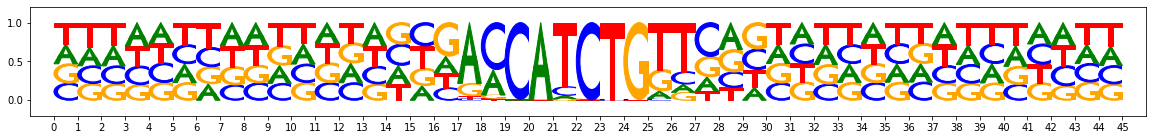

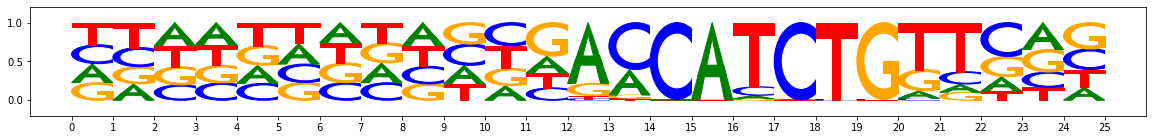

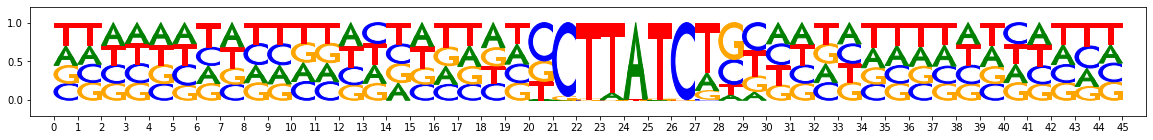

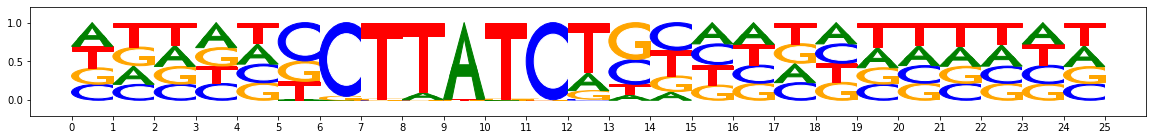

In [84]:
for orig_pattern,trimmed_pattern in zip(orig_patterns, trimmed_subclustered_patterns):
    viz_sequence.plot_weights(orig_pattern["sequence"].fwd)
    viz_sequence.plot_weights(trimmed_pattern["sequence"].fwd)

In [155]:
import modisco.util
reload(modisco.util)
reload(modisco.cluster.core)
from modisco import hit_scoring
reload(modisco.hit_scoring)
from modisco.hit_scoring import densityadapted_hitscoring
reload(modisco.hit_scoring.densityadapted_hitscoring)
from modisco.hit_scoring import densityadapted_hitscoring
reload(modisco.seqlet_embedding.advanced_gapped_kmer)
reload(modisco.seqlet_embedding)

min_overlap_size = 10
seqlet_scorer = densityadapted_hitscoring.prepare_seqlet_scorer(
    patterns=trimmed_subclustered_patterns,
    onehot_track_name=onehot_track_name,
    task_names_and_signs=[(x,1) for x in task_names],
    n_cores=n_cores,
    max_seqlets_per_submotif=100,
    min_overlap_size=min_overlap_size)

Pattern length (and hence target seqlet size) is 25
Subsampling subpattern 0
Subsampling subpattern 1
Subsampling subpattern 2
Subsampling subpattern 6
Prepare seqlet scorer
Computing coarse-grained embeddings


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 236 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 736 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 910 out of 910 | elapsed:   28.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done 903 out of 910 | elapsed:   27.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 910 out of 910 | elapsed:   27.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 910 out of 910 | elapsed:    2.0s finished


Constructing csr matrix...
csr matrix made in 0.21549487113952637 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 910 out of 910 | elapsed:    2.0s finished


Constructing csr matrix...
csr matrix made in 0.19937682151794434 s
Computing coarse top k nn via cosine sim
Batching in slices of size 910


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

Computing fine-grained sim for top k
Launching nearest neighbors affmat calculation job
MEMORY 1.599889408


Parallel runs completed
MEMORY 1.601277952
Job completed in: 9.27 s
MEMORY 1.601277952
Launching nearest neighbors affmat calculation job
MEMORY 1.601277952
Parallel runs completed
MEMORY 1.601298432
Job completed in: 9.95 s
MEMORY 1.601298432
Mapping affinity to distmat
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
Computing density-adapted nn affmat
Beginning preprocessing + Leiden


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.0s


Quality: 0.0014592811411796036


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.1s


Quality: 0.3324673924206436
Quality: 0.3327563564180049
Quality: 0.332774074766855
Quality: 0.3327757788013743


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   15.3s finished


Number of reclustered idxs: 9
{(0, 1), (4, 0), (7, 1), (2, 1), (8, 1), (6, 1), (5, 1), (3, 0), (1, 0)}
Preparing modularity scorer
Accuracy: 0.989010989010989


In [156]:
#investigate mis-assigned seqlets
pattern0_classes, pattern0_precisions, pattern0_percentiles, pattern0_moddeltas = seqlet_scorer(trimmed_subclustered_patterns[0].seqlets)
pattern1_classes, pattern1_precisions, pattern1_percentiles, pattern1_moddeltas = seqlet_scorer(trimmed_subclustered_patterns[1].seqlets)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 600 out of 607 | elapsed:   17.8s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 607 out of 607 | elapsed:   18.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 607 out of 607 | elapsed:    1.4s finished


Constructing csr matrix...
csr matrix made in 0.16628408432006836 s
Batching in slices of size 607


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

Launching nearest neighbors affmat calculation job
MEMORY 1.62603008


Parallel runs completed
MEMORY 1.626066944
Job completed in: 6.33 s
MEMORY 1.626042368
Launching nearest neighbors affmat calculation job
MEMORY 1.626042368
Parallel runs completed
MEMORY 1.626042368
Job completed in: 6.3 s
MEMORY 1.626042368


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 530 out of 537 | elapsed:   17.3s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 537 out of 537 | elapsed:   17.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.12079000473022461 s
Batching in slices of size 537


[Parallel(n_jobs=1)]: Done 537 out of 537 | elapsed:    1.4s finished
100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

Launching nearest neighbors affmat calculation job
MEMORY 1.626288128


Parallel runs completed
MEMORY 1.626300416
Job completed in: 5.34 s
MEMORY 1.626300416
Launching nearest neighbors affmat calculation job
MEMORY 1.626300416
Parallel runs completed
MEMORY 1.626300416
Job completed in: 5.62 s
MEMORY 1.626300416


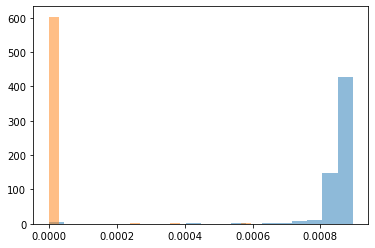

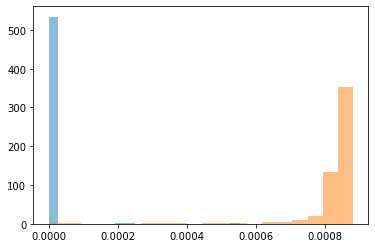

In [157]:
plt.hist(pattern0_moddeltas[:,0], bins=20, alpha=0.5)
plt.hist(pattern0_moddeltas[:,1], bins=20, alpha=0.5)
plt.show()
plt.hist(pattern1_moddeltas[:,0], bins=20, alpha=0.5)
plt.hist(pattern1_moddeltas[:,1], bins=20, alpha=0.5)
plt.show()

Misclassified seqlets from pattern 0
precision: 0.975
percentile: 0.09195402298850575
modularitydeltas: [-2.22752720e-06  2.67208281e-04]


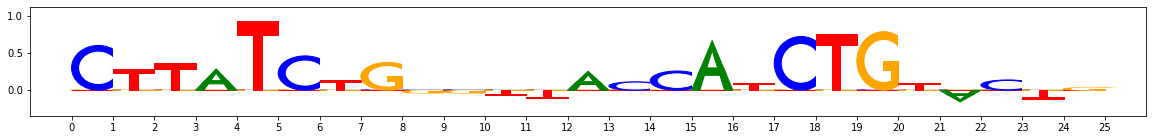

precision: 0.975
percentile: 0.13601532567049812
modularitydeltas: [-2.19307518e-06  3.59832075e-04]


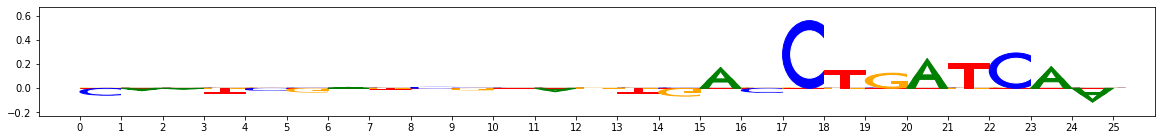

precision: 1.0
percentile: 0.31417624521072796
modularitydeltas: [4.01284723e-06 5.95295849e-04]


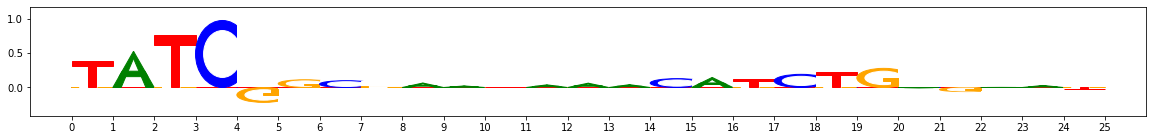

precision: 1.0
percentile: 0.30268199233716475
modularitydeltas: [3.61270173e-06 5.89795080e-04]


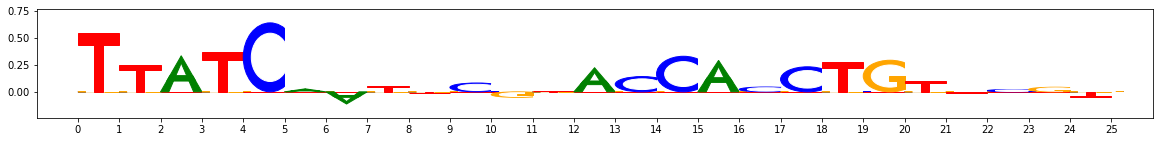

Misclassified seqlets from pattern 1
precision: 0.3076923076923077
percentile: 0.010309278350515427
modularitydeltas: [2.39549057e-04 1.00764316e-05]


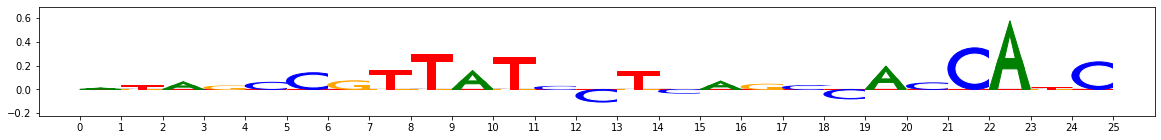

precision: 0.3076923076923077
percentile: 0.010309278350515427
modularitydeltas: [1.92102300e-04 1.39208279e-05]


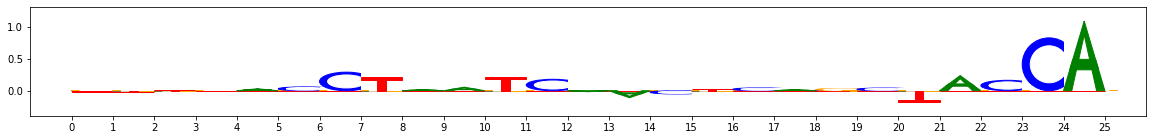

precision: 0.7501768273293616
percentile: 0.012886597938144284
modularitydeltas: [5.51478718e-04 4.40520575e-06]


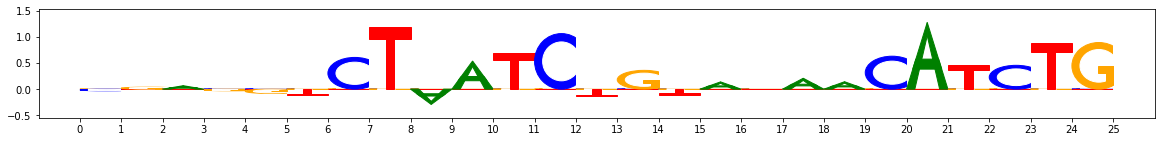

In [158]:
#visualize the mis-classified seqlets from the original patterns
print("Misclassified seqlets from pattern 0")
pattern0_seqlets = trimmed_subclustered_patterns[0].seqlets
for misclassified_pattern0_idx in np.nonzero(pattern0_classes==1)[0]:
    print("precision:",pattern0_precisions[misclassified_pattern0_idx])
    print("percentile:",pattern0_percentiles[misclassified_pattern0_idx])
    print("modularitydeltas:",pattern0_moddeltas[misclassified_pattern0_idx])
    viz_sequence.plot_weights(pattern0_seqlets[misclassified_pattern0_idx]["task0_contrib_scores"].fwd)

print("Misclassified seqlets from pattern 1")
pattern1_seqlets = trimmed_subclustered_patterns[1].seqlets
for misclassified_pattern1_idx in np.nonzero(pattern1_classes==0)[0]:
    print("precision:",pattern1_precisions[misclassified_pattern1_idx])
    print("percentile:",pattern1_percentiles[misclassified_pattern1_idx])
    print("modularitydeltas:",pattern1_moddeltas[misclassified_pattern1_idx])
    viz_sequence.plot_weights(pattern1_seqlets[misclassified_pattern1_idx]["task0_contrib_scores"].fwd)

Fitting - on window size 7
peak(mu)= -0.0074628859525546435
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.30555383567580957 occurring at 1.475214958190918e-06 implying a frac_neg of 0.43999643366619123
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.16537335524525754 occurring at -9.5367431640625e-07 implying a frac_neg of 0.19814051742123928
To be conservative, adjusted frac neg is 0.95


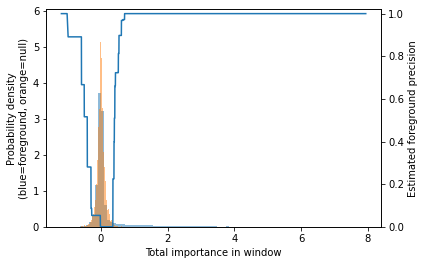

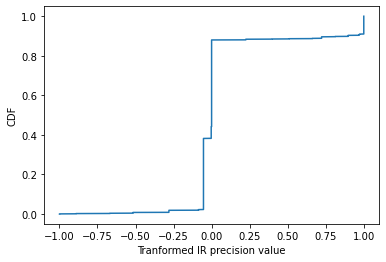

Thresholds from null dist were -0.8  and  0.8 with frac passing 0.1055375
Got 2789 coords


In [102]:
#Use a CoordProducer object to get candidate seqlet coordintes

#The reason I am not using the original CoordProducer settings from the initial
# tf-modisco run is that at the stage of hit-scoring, you may want to have more sensitivity,
# and that would lead to different ideal settings as compared to the original run.
#We will also use VariableWindowAroundChunks even though we specify a single window size
# as this coordproducer is set up to score based on precision w.r.t. a. null
reload(modisco.coordproducers)
import numpy as np

core_sliding_window = 7 #on the shorter side, for sensitivity
assert (target_seqlet_size-core_sliding_window)%2 == 0 #need even flanks on either side
coordproducer = modisco.coordproducers.VariableWindowAroundChunks(
    sliding=[core_sliding_window], #the core sliding window size to use
    flank=int((target_seqlet_size-core_sliding_window)/2.0),
    #suppress = how many windows on either side of the core window to suppress.
    #suppress=core_sliding_window_size means that additional sliding windows that overlap
    # the core are not allowed
    suppress=core_sliding_window,
    target_fdr=0.2,
    min_passing_windows_frac=0.03,
    max_passing_windows_frac=0.2,      
    separate_pos_neg_thresholds=False,                             
    max_seqlets_total=np.inf)
coordproducer_results = coordproducer(score_track=np.sum(task_to_scores["task0"], axis=-1),
                       #can also supply an empirical null distribution
                       null_track=modisco.coordproducers.LaplaceNullDist(num_to_samp=10000)
                      )



In [111]:
#fetch seqlets associated with the coordinates
seqlets = track_set.create_seqlets(coordproducer_results.coords)
#get the precision values associated with each seqlet
value_provider = modisco.value_provider.TransformCentralWindowValueProvider(
                    track_name="task0_contrib_scores",
                    central_window=[core_sliding_window],
                    val_transformer=coordproducer_results.tnt_results.val_transformer)
seqlet_irprecision = [value_provider(x) for x in seqlets]
pos_seqlets, pos_seqlets_irprecisions = list(
    zip(*[x for x in zip(seqlets, seqlet_irprecision) if x[1] > 0]))

In [115]:
print("Number of pos seqlets:",len(pos_seqlets))

Number of pos seqlets: 2707


In [159]:
#Score these seqlets
#posseqlet_classes = the pattern idx that got mapped to
(posseqlet_classes, posseqlet_precisions, posseqlet_percentiles, seqlet_moddeltas) =\
    seqlet_scorer(pos_seqlets)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   45.9s
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 2707 out of 2707 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2707 out of 2707 | elapsed:    6.1s finished


Constructing csr matrix...
csr matrix made in 0.6360020637512207 s
Batching in slices of size 2707


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Launching nearest neighbors affmat calculation job
MEMORY 1.621774336
Parallel runs completed
MEMORY 1.621774336
Job completed in: 25.93 s
MEMORY 1.621774336
Launching nearest neighbors affmat calculation job
MEMORY 1.621774336
Parallel runs completed
MEMORY 1.621774336
Job completed in: 28.52 s
MEMORY 1.621774336


In [160]:
#For each seqlet, get the alignment for the class that it maps to
from collections import defaultdict
from collections import namedtuple

MotifMatch = namedtuple("MotifMatch", ["patternidx", "exampleidx", "start", "end", "is_revcomp",
                                       "crosscontin_sim", "modularity_precision",
                                       "modularity_percentile"])

pattern_aligner = modisco.core.CrossContinJaccardPatternAligner(              
    pattern_comparison_settings=
        modisco.affinitymat.core.PatternComparisonSettings(                         
                track_names=["task0_hypothetical_contribs", "task0_contrib_scores"],                      
                track_transformer=modisco.affinitymat.L1Normalizer(),
                min_overlap=float(min_overlap_size)/target_seqlet_size))

motifmatches = []
for seqletidx,(seqlet, patternidx) in enumerate(zip(pos_seqlets, posseqlet_classes)):
    assert seqlet.coor.is_revcomp==False
    mappedtomotif = trimmed_subclustered_patterns[patternidx]
    alignment, rc, sim = pattern_aligner(parent_pattern=seqlet,
                                         child_pattern=mappedtomotif)
    motifmatch = MotifMatch(patternidx=patternidx,
                   exampleidx=seqlet.coor.example_idx,
                   start=seqlet.coor.start+alignment,
                   end=seqlet.coor.start+alignment+len(mappedtomotif),
                   is_revcomp=rc,
                   crosscontin_sim=sim,
                   modularity_precision=posseqlet_precisions[seqletidx],
                   modularity_percentile=posseqlet_percentiles[seqletidx])
    motifmatches.append(motifmatch)
    
#Remove duplicate motif matches that can occur due to overlapping seqlets
unique_motifmatches = []
motifmatches_set = set()
patternidx_to_matches = defaultdict(list)
exampleidx_to_matches = defaultdict(list)
duplicates_found = 0
for motifmatch in motifmatches:
    match_identifier = (motifmatch.patternidx, motifmatch.exampleidx, motifmatch.start,
                        motifmatch.end, motifmatch.is_revcomp)
    if match_identifier not in motifmatches_set:
        unique_motifmatches.append(motifmatch)
        patternidx_to_matches[motifmatch.patternidx].append(motifmatch)
        exampleidx_to_matches[motifmatch.exampleidx].append(motifmatch)
    else:
        duplicates_found += 1
    motifmatches_set.add(match_identifier)
print("Removed",duplicates_found,"duplicates")

Removed 1082 duplicates


MotifMatch(patternidx=0, exampleidx=0, start=123, end=148, is_revcomp=True, crosscontin_sim=0.4716773236775358, modularity_precision=1.0, modularity_percentile=0.4561855670103093)
MotifMatch(patternidx=1, exampleidx=0, start=141, end=166, is_revcomp=True, crosscontin_sim=0.5693751421288773, modularity_precision=1.0, modularity_percentile=1.0)
MotifMatch(patternidx=0, exampleidx=0, start=166, end=191, is_revcomp=True, crosscontin_sim=0.5134378588641366, modularity_precision=1.0, modularity_percentile=0.22680412371134018)


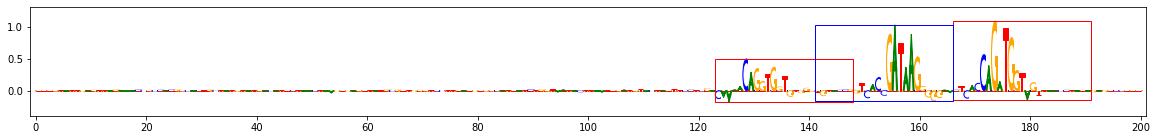

MotifMatch(patternidx=1, exampleidx=1, start=67, end=92, is_revcomp=False, crosscontin_sim=0.40796096209414695, modularity_precision=1.0, modularity_percentile=0.6283524904214559)
MotifMatch(patternidx=1, exampleidx=1, start=91, end=116, is_revcomp=False, crosscontin_sim=0.34822048297039154, modularity_precision=1.0, modularity_percentile=0.8601532567049809)
MotifMatch(patternidx=1, exampleidx=1, start=158, end=183, is_revcomp=False, crosscontin_sim=0.3223179923562603, modularity_precision=1.0, modularity_percentile=0.5804597701149425)


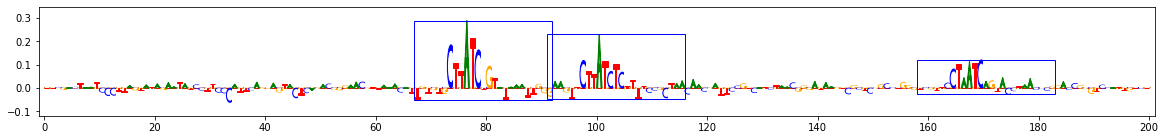

MotifMatch(patternidx=0, exampleidx=2, start=10, end=35, is_revcomp=True, crosscontin_sim=0.3869143689073967, modularity_precision=1.0, modularity_percentile=0.1030927835051546)
MotifMatch(patternidx=0, exampleidx=2, start=67, end=92, is_revcomp=True, crosscontin_sim=0.5682445898232736, modularity_precision=1.0, modularity_percentile=0.09793814432989689)
MotifMatch(patternidx=0, exampleidx=2, start=149, end=174, is_revcomp=True, crosscontin_sim=0.5315187684547668, modularity_precision=1.0, modularity_percentile=0.46649484536082475)


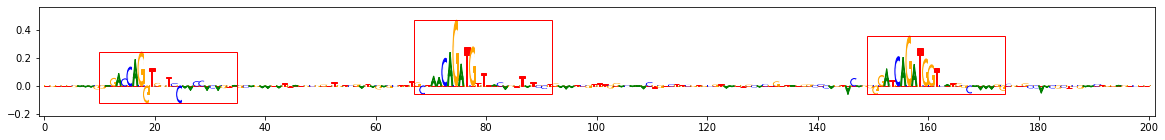

MotifMatch(patternidx=1, exampleidx=3, start=68, end=93, is_revcomp=False, crosscontin_sim=0.6025110329475831, modularity_precision=1.0, modularity_percentile=0.9597701149425287)
MotifMatch(patternidx=0, exampleidx=3, start=91, end=116, is_revcomp=False, crosscontin_sim=0.5740798447287689, modularity_precision=1.0, modularity_percentile=0.46649484536082475)
MotifMatch(patternidx=0, exampleidx=3, start=122, end=147, is_revcomp=False, crosscontin_sim=0.5842946517280385, modularity_precision=1.0, modularity_percentile=0.904639175257732)
MotifMatch(patternidx=0, exampleidx=3, start=158, end=183, is_revcomp=False, crosscontin_sim=0.5289994336713055, modularity_precision=1.0, modularity_percentile=0.25257731958762886)
MotifMatch(patternidx=1, exampleidx=3, start=24, end=49, is_revcomp=False, crosscontin_sim=0.2990807565091995, modularity_precision=1.0, modularity_percentile=0.6704980842911877)


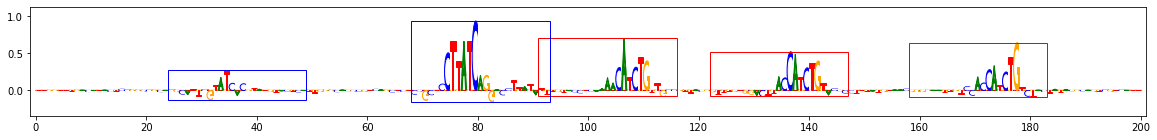

MotifMatch(patternidx=1, exampleidx=6, start=161, end=186, is_revcomp=True, crosscontin_sim=0.2512024716922842, modularity_precision=1.0, modularity_percentile=0.2931034482758621)


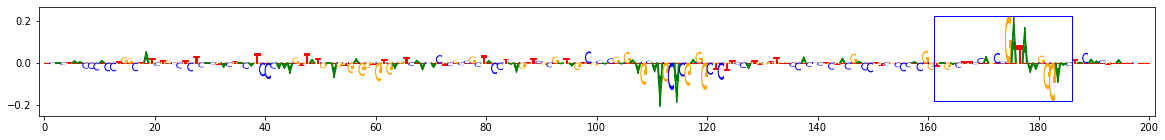

MotifMatch(patternidx=1, exampleidx=8, start=27, end=52, is_revcomp=False, crosscontin_sim=0.4154959575959678, modularity_precision=1.0, modularity_percentile=0.9444444444444444)
MotifMatch(patternidx=1, exampleidx=8, start=89, end=114, is_revcomp=False, crosscontin_sim=0.45457465761741345, modularity_precision=1.0, modularity_percentile=0.9808429118773946)
MotifMatch(patternidx=1, exampleidx=8, start=135, end=160, is_revcomp=False, crosscontin_sim=0.37215707887574223, modularity_precision=1.0, modularity_percentile=0.7586206896551724)


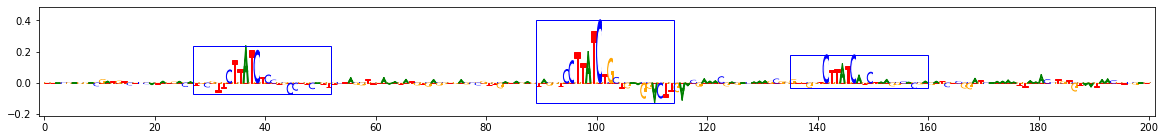

MotifMatch(patternidx=1, exampleidx=9, start=27, end=52, is_revcomp=False, crosscontin_sim=0.5967994574345831, modularity_precision=1.0, modularity_percentile=0.9501915708812261)
MotifMatch(patternidx=0, exampleidx=9, start=75, end=100, is_revcomp=False, crosscontin_sim=0.5890417097800731, modularity_precision=1.0, modularity_percentile=0.7396907216494846)
MotifMatch(patternidx=1, exampleidx=9, start=165, end=190, is_revcomp=False, crosscontin_sim=0.5932872304060121, modularity_precision=1.0, modularity_percentile=0.9961685823754789)


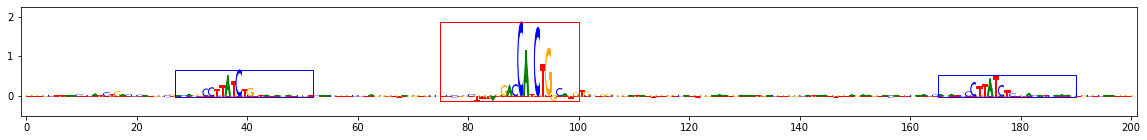

MotifMatch(patternidx=1, exampleidx=10, start=124, end=149, is_revcomp=True, crosscontin_sim=0.4991995285893811, modularity_precision=1.0, modularity_percentile=0.9961685823754789)


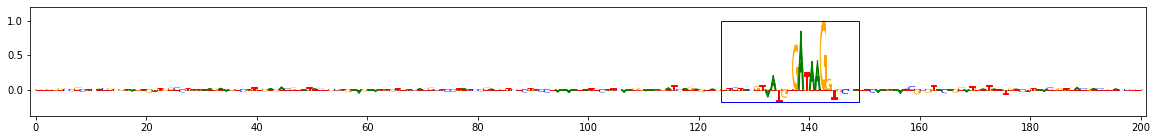

MotifMatch(patternidx=0, exampleidx=11, start=41, end=66, is_revcomp=False, crosscontin_sim=0.6001562706781338, modularity_precision=1.0, modularity_percentile=0.33247422680412375)
MotifMatch(patternidx=1, exampleidx=11, start=98, end=123, is_revcomp=False, crosscontin_sim=0.4485793005015102, modularity_precision=1.0, modularity_percentile=0.43486590038314177)


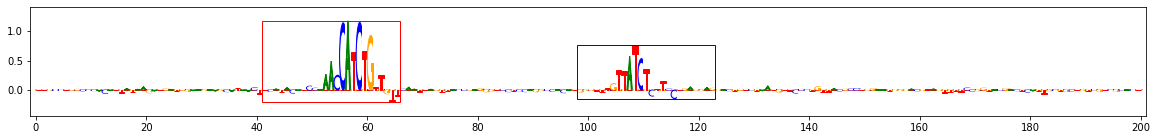

MotifMatch(patternidx=0, exampleidx=12, start=88, end=113, is_revcomp=False, crosscontin_sim=0.5994944275223221, modularity_precision=1.0, modularity_percentile=0.7474226804123711)
MotifMatch(patternidx=1, exampleidx=12, start=131, end=156, is_revcomp=False, crosscontin_sim=0.5956155031173463, modularity_precision=1.0, modularity_percentile=1.0)
MotifMatch(patternidx=1, exampleidx=12, start=176, end=201, is_revcomp=False, crosscontin_sim=0.5868229023032439, modularity_precision=1.0, modularity_percentile=0.9597701149425287)


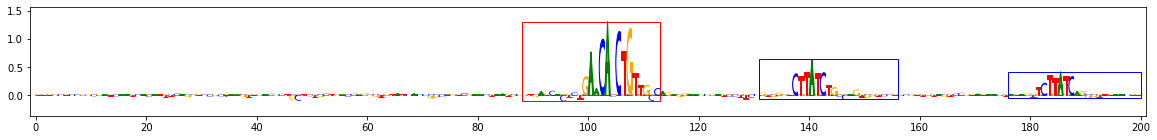

MotifMatch(patternidx=0, exampleidx=13, start=0, end=25, is_revcomp=False, crosscontin_sim=0.5131107306199416, modularity_precision=1.0, modularity_percentile=0.18814432989690721)
MotifMatch(patternidx=1, exampleidx=13, start=178, end=203, is_revcomp=False, crosscontin_sim=0.5262842621435563, modularity_precision=1.0, modularity_percentile=0.6915708812260537)


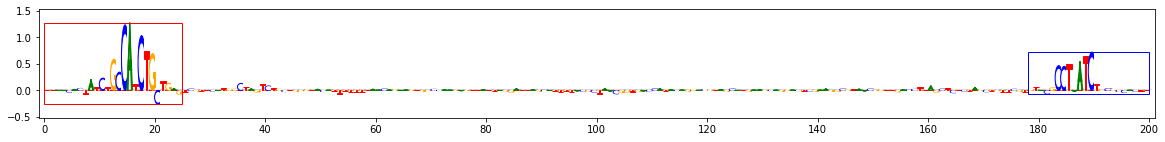

MotifMatch(patternidx=1, exampleidx=14, start=38, end=63, is_revcomp=True, crosscontin_sim=0.35755459577799137, modularity_precision=1.0, modularity_percentile=0.8352490421455938)


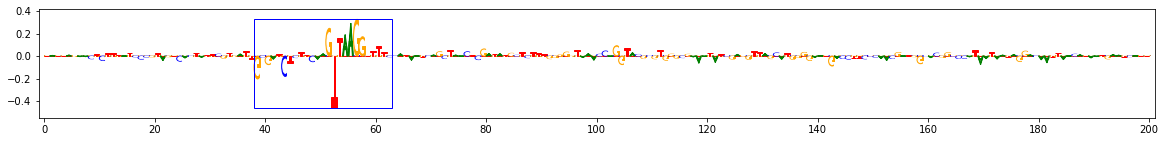

MotifMatch(patternidx=1, exampleidx=15, start=114, end=139, is_revcomp=False, crosscontin_sim=0.5585697853209832, modularity_precision=1.0, modularity_percentile=0.9961685823754789)
MotifMatch(patternidx=0, exampleidx=15, start=161, end=186, is_revcomp=False, crosscontin_sim=0.621661006468233, modularity_precision=1.0, modularity_percentile=0.2757731958762887)


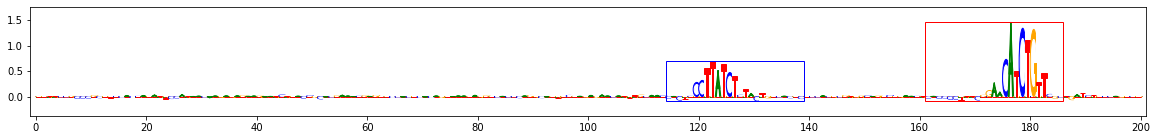

MotifMatch(patternidx=0, exampleidx=16, start=24, end=49, is_revcomp=False, crosscontin_sim=0.21554788841723893, modularity_precision=1.0, modularity_percentile=0.01804123711340211)
MotifMatch(patternidx=1, exampleidx=16, start=44, end=69, is_revcomp=False, crosscontin_sim=0.3359422880510883, modularity_precision=1.0, modularity_percentile=0.8697318007662835)
MotifMatch(patternidx=1, exampleidx=16, start=92, end=117, is_revcomp=False, crosscontin_sim=0.4793973380773036, modularity_precision=1.0, modularity_percentile=0.9674329501915708)


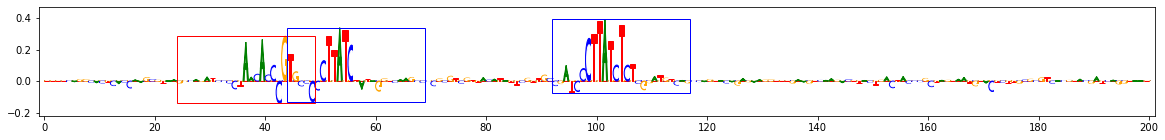

MotifMatch(patternidx=1, exampleidx=17, start=12, end=37, is_revcomp=True, crosscontin_sim=0.36505218915386617, modularity_precision=1.0, modularity_percentile=0.5191570881226053)
MotifMatch(patternidx=0, exampleidx=17, start=60, end=85, is_revcomp=True, crosscontin_sim=0.5050227226618305, modularity_precision=1.0, modularity_percentile=0.14175257731958768)


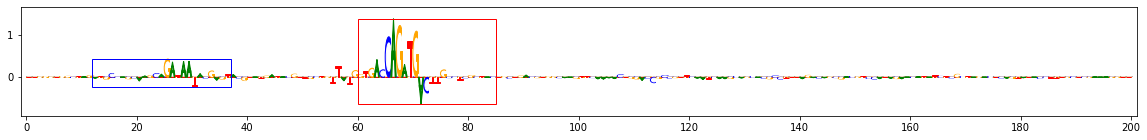

MotifMatch(patternidx=1, exampleidx=18, start=104, end=129, is_revcomp=False, crosscontin_sim=0.6368534692260289, modularity_precision=1.0, modularity_percentile=1.0)
MotifMatch(patternidx=0, exampleidx=18, start=111, end=136, is_revcomp=False, crosscontin_sim=0.4001895035254002, modularity_precision=1.0, modularity_percentile=0.07731958762886593)


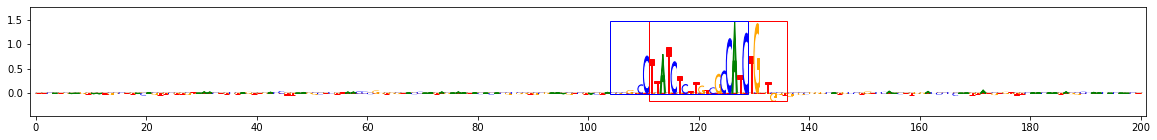

MotifMatch(patternidx=1, exampleidx=19, start=23, end=48, is_revcomp=False, crosscontin_sim=0.4600977218318936, modularity_precision=1.0, modularity_percentile=0.9386973180076629)
MotifMatch(patternidx=0, exampleidx=19, start=138, end=163, is_revcomp=False, crosscontin_sim=0.3102000459496142, modularity_precision=0.40584632399669096, modularity_percentile=0.010309278350515427)
MotifMatch(patternidx=1, exampleidx=19, start=139, end=164, is_revcomp=True, crosscontin_sim=0.1537492250153663, modularity_precision=1.0, modularity_percentile=0.2183908045977011)


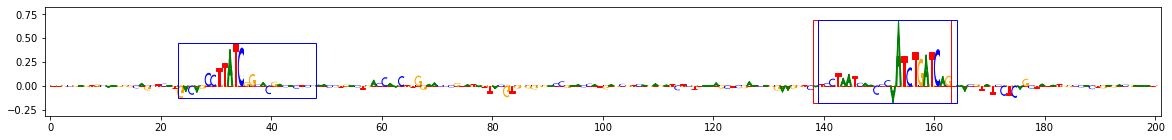

MotifMatch(patternidx=1, exampleidx=20, start=15, end=40, is_revcomp=True, crosscontin_sim=0.565809016254771, modularity_precision=1.0, modularity_percentile=1.0)


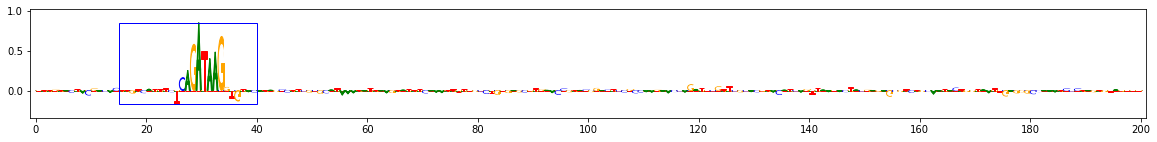

MotifMatch(patternidx=0, exampleidx=21, start=10, end=35, is_revcomp=False, crosscontin_sim=0.5272604066809783, modularity_precision=1.0, modularity_percentile=0.6056701030927836)
MotifMatch(patternidx=1, exampleidx=21, start=56, end=81, is_revcomp=False, crosscontin_sim=0.5816138587082292, modularity_precision=1.0, modularity_percentile=0.9865900383141762)
MotifMatch(patternidx=0, exampleidx=21, start=87, end=112, is_revcomp=False, crosscontin_sim=0.6214660537410079, modularity_precision=1.0, modularity_percentile=0.19329896907216493)
MotifMatch(patternidx=1, exampleidx=21, start=130, end=155, is_revcomp=False, crosscontin_sim=0.4639497998328219, modularity_precision=1.0, modularity_percentile=0.8869731800766284)
MotifMatch(patternidx=1, exampleidx=21, start=174, end=199, is_revcomp=False, crosscontin_sim=0.5804907160349995, modularity_precision=1.0, modularity_percentile=0.9942528735632183)


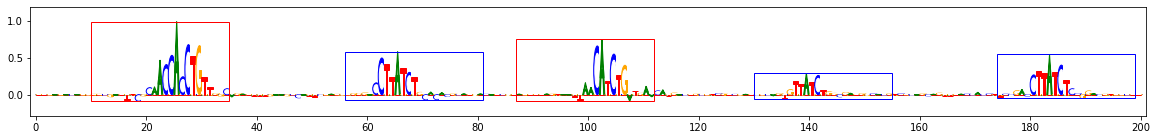

MotifMatch(patternidx=0, exampleidx=23, start=109, end=134, is_revcomp=True, crosscontin_sim=0.49599008302884884, modularity_precision=1.0, modularity_percentile=0.22938144329896903)
MotifMatch(patternidx=0, exampleidx=23, start=126, end=151, is_revcomp=True, crosscontin_sim=0.5347021801095578, modularity_precision=1.0, modularity_percentile=0.4072164948453608)
MotifMatch(patternidx=0, exampleidx=23, start=26, end=51, is_revcomp=True, crosscontin_sim=0.40685421208641415, modularity_precision=1.0, modularity_percentile=0.11082474226804129)


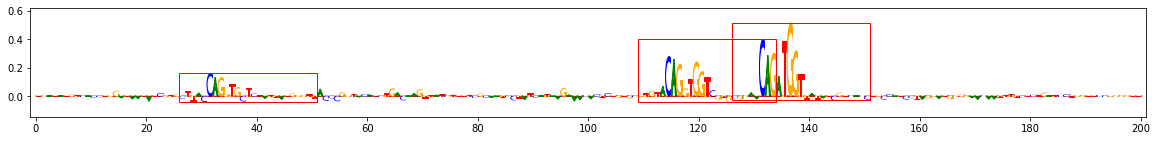

MotifMatch(patternidx=1, exampleidx=24, start=35, end=60, is_revcomp=False, crosscontin_sim=0.4411992617111804, modularity_precision=1.0, modularity_percentile=0.9674329501915708)
MotifMatch(patternidx=1, exampleidx=24, start=127, end=152, is_revcomp=False, crosscontin_sim=0.4678001397625813, modularity_precision=1.0, modularity_percentile=0.9540229885057472)


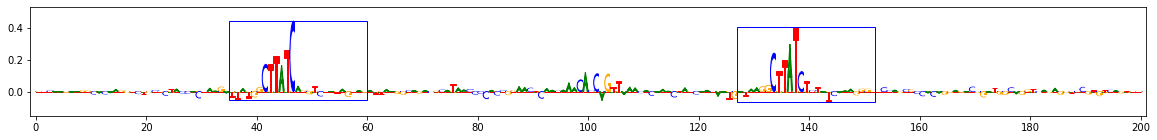

MotifMatch(patternidx=0, exampleidx=25, start=7, end=32, is_revcomp=False, crosscontin_sim=0.45621394921958286, modularity_precision=1.0, modularity_percentile=0.12371134020618557)
MotifMatch(patternidx=0, exampleidx=25, start=57, end=82, is_revcomp=False, crosscontin_sim=0.6075284443030865, modularity_precision=1.0, modularity_percentile=0.40463917525773196)
MotifMatch(patternidx=0, exampleidx=25, start=123, end=148, is_revcomp=False, crosscontin_sim=0.4320352981578973, modularity_precision=1.0, modularity_percentile=0.17268041237113407)


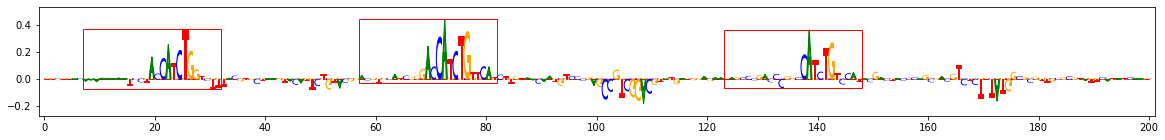

MotifMatch(patternidx=1, exampleidx=27, start=61, end=86, is_revcomp=False, crosscontin_sim=0.2972553527147604, modularity_precision=1.0, modularity_percentile=0.5478927203065134)


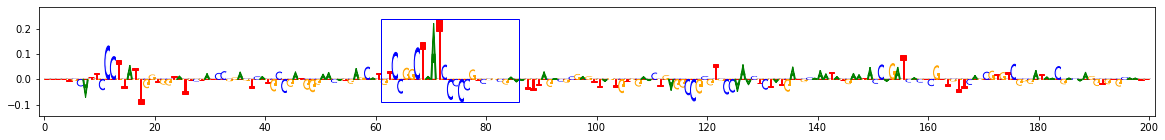

MotifMatch(patternidx=0, exampleidx=28, start=17, end=42, is_revcomp=True, crosscontin_sim=0.5532519173588295, modularity_precision=1.0, modularity_percentile=0.0798969072164949)
MotifMatch(patternidx=0, exampleidx=28, start=155, end=180, is_revcomp=True, crosscontin_sim=0.5521355217719193, modularity_precision=1.0, modularity_percentile=0.25257731958762886)
MotifMatch(patternidx=0, exampleidx=28, start=182, end=207, is_revcomp=True, crosscontin_sim=0.4926815878087064, modularity_precision=1.0, modularity_percentile=0.2319587628865979)


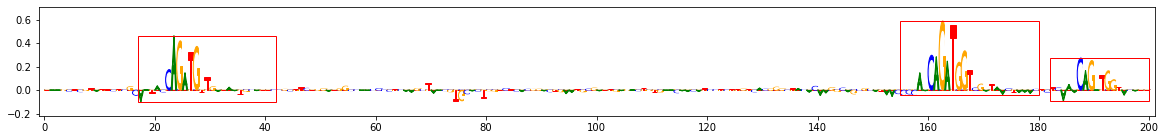

MotifMatch(patternidx=1, exampleidx=29, start=57, end=82, is_revcomp=False, crosscontin_sim=0.4924179130518349, modularity_precision=1.0, modularity_percentile=0.9636015325670498)
MotifMatch(patternidx=0, exampleidx=29, start=155, end=180, is_revcomp=False, crosscontin_sim=0.5668649356640264, modularity_precision=1.0, modularity_percentile=0.884020618556701)


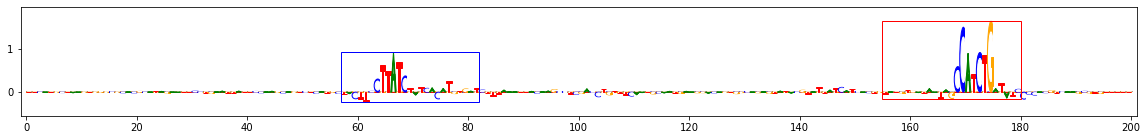

MotifMatch(patternidx=0, exampleidx=30, start=60, end=85, is_revcomp=False, crosscontin_sim=0.4555836367867322, modularity_precision=1.0, modularity_percentile=0.19845360824742264)
MotifMatch(patternidx=1, exampleidx=30, start=71, end=96, is_revcomp=False, crosscontin_sim=0.1636628639045734, modularity_precision=0.9642857142857143, modularity_percentile=0.05555555555555558)


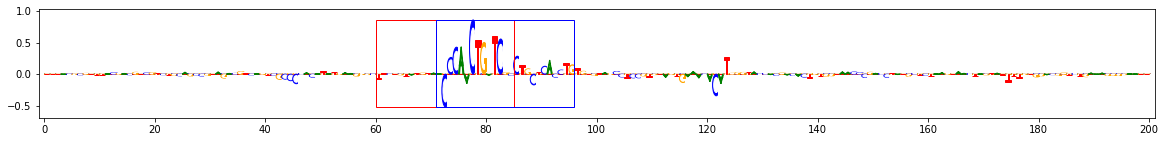

MotifMatch(patternidx=0, exampleidx=31, start=19, end=44, is_revcomp=True, crosscontin_sim=0.6489231140024554, modularity_precision=1.0, modularity_percentile=0.20360824742268047)
MotifMatch(patternidx=0, exampleidx=31, start=138, end=163, is_revcomp=True, crosscontin_sim=0.4867240562953496, modularity_precision=1.0, modularity_percentile=0.12628865979381443)


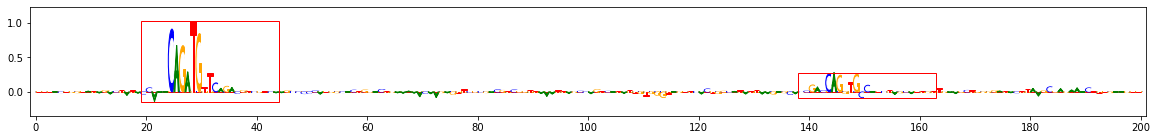

MotifMatch(patternidx=0, exampleidx=32, start=93, end=118, is_revcomp=False, crosscontin_sim=0.42676809783338976, modularity_precision=1.0, modularity_percentile=0.04381443298969068)


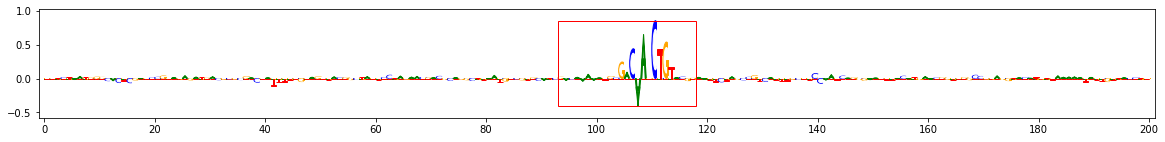

MotifMatch(patternidx=0, exampleidx=33, start=65, end=90, is_revcomp=True, crosscontin_sim=0.4853801022025071, modularity_precision=1.0, modularity_percentile=0.07474226804123707)
MotifMatch(patternidx=0, exampleidx=33, start=106, end=131, is_revcomp=True, crosscontin_sim=0.41176898286660324, modularity_precision=1.0, modularity_percentile=0.08505154639175261)
MotifMatch(patternidx=0, exampleidx=33, start=175, end=200, is_revcomp=True, crosscontin_sim=0.5165818419038778, modularity_precision=1.0, modularity_percentile=0.10051546391752575)


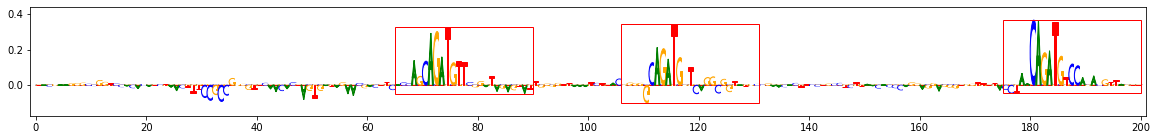

MotifMatch(patternidx=0, exampleidx=34, start=88, end=113, is_revcomp=False, crosscontin_sim=0.5947384923495663, modularity_precision=1.0, modularity_percentile=0.3917525773195877)


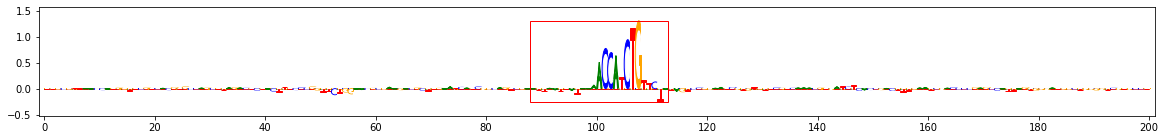

In [161]:
from modisco.visualization import viz_sequence

#visualize the matches
for exampleidx in list(sorted(exampleidx_to_matches.keys()))[:30]:
    matches = exampleidx_to_matches[exampleidx]
    for match in matches:
        print(match)
    
    viz_sequence.plot_weights(
        task_to_scores["task0"][exampleidx],
        highlight={'red': [
            (max(x.start,0), min(x.end,len(task_to_scores["task0"][exampleidx])))
             for x in matches if x.patternidx==0],
                   'blue': [
            (max(x.start,0), min(x.end,len(task_to_scores["task0"][exampleidx])) )
             for x in matches if x.patternidx==1]},
        subticks_frequency=20)

In [135]:
len(patternidx_to_matches[1])

786

From our retained hits, let us visualize the first few matches to the GATA motif.

cosine similarity: 0.9730466132159148 sum scores: 4.67945


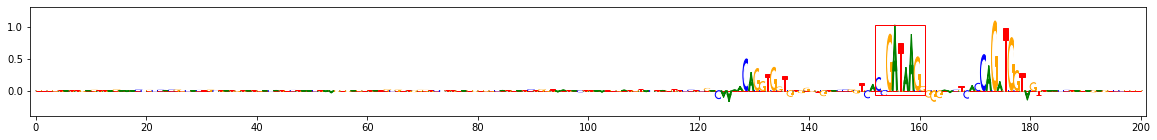

cosine similarity: 0.9718488473936472 sum scores: 4.3328032


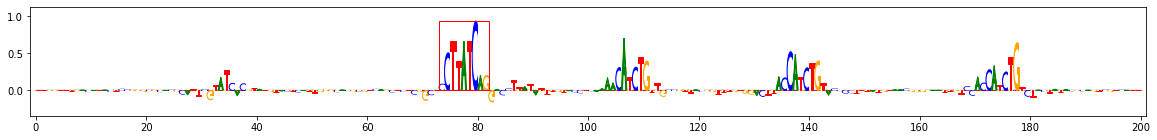

cosine similarity: 0.92635470334193 sum scores: 2.7548823


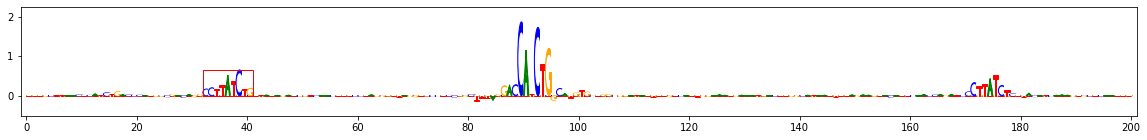

cosine similarity: 0.9739376413725628 sum scores: 2.3730216


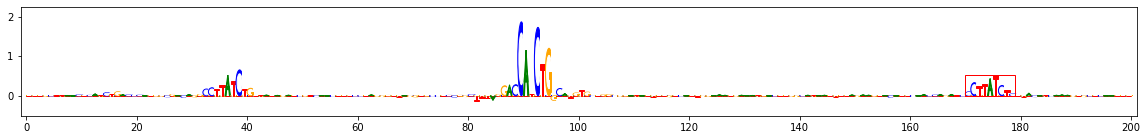

cosine similarity: 0.9107049245615534 sum scores: 3.638939


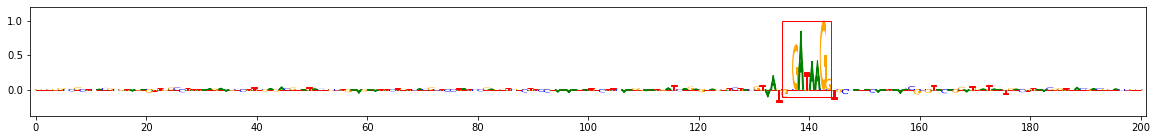

In [15]:
hit_locations = list(zip(*np.nonzero(threshold_passers)))
num_to_viz = 5
for (seq_idx, hit_pos) in hit_locations[:num_to_viz]:
    print("cosine similarity:", masked_cosine_sim[seq_idx,hit_pos],
          "sum scores:", sum_scores[seq_idx, hit_pos])
    viz_sequence.plot_weights(
        imp_scores[seq_idx],
        highlight={'red': [(hit_pos, hit_pos+len(trimmed_gata))]},
        subticks_frequency=20)


Let us also visualize some regions that are very strong matches to the log-odds PWM, but which did not have a sufficiently high value for sum_scores and were thus not called as matches at our chosen sum_scores threshold (which was on the stringent sides). It turns out that these regions tend to lack the TAL (CAGATG) motif. Since task 0 is a 1 iff both TAL and GATA motifs are present in the sequence, it makes sense that GATA motifs in the absence of TAL would receive lower importance. This illustrates how looking at the importance scores at motif instances incorporates information about the surrounding context, such as the presence or absence of cofactors.

logodds pwm score: 8.049250092863117 sum scores: 1.6806582


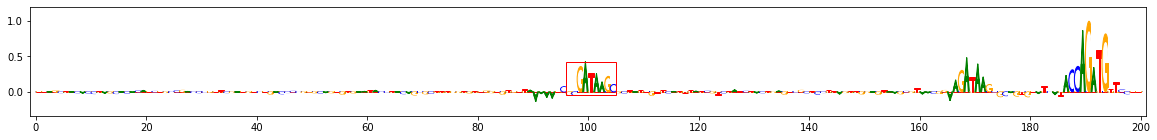

logodds pwm score: 8.038079095629165 sum scores: 1.7580922


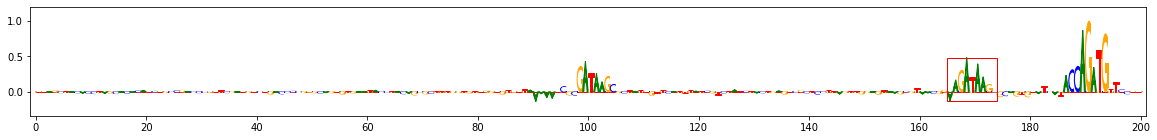

logodds pwm score: 9.27711663216828 sum scores: 1.5461156


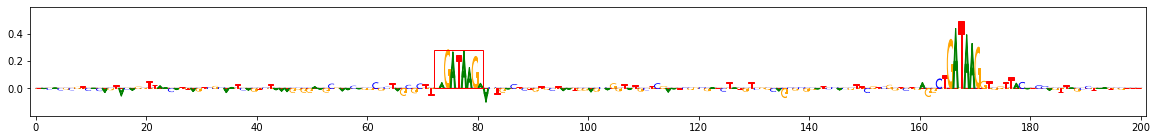

logodds pwm score: 10.0680721367655 sum scores: 1.2932366


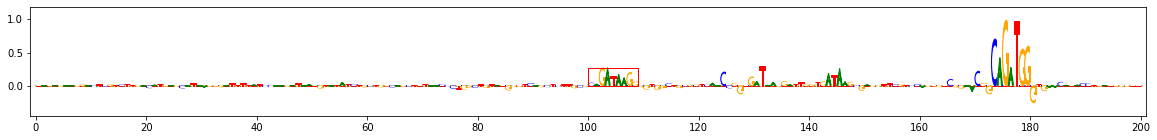

logodds pwm score: 8.758303189768567 sum scores: 0.49651676


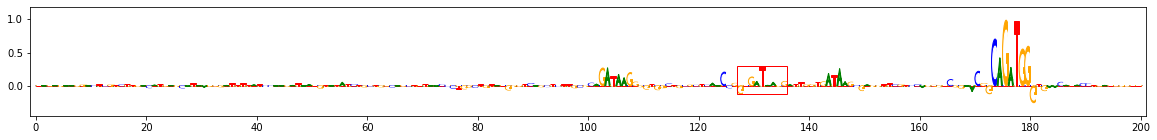

In [16]:
#To compute scores from a simple log-odds pwm scan, we can use the code below
# Note that because the simulation was generated using a position probability matrix (ppm), the scanning
# with the log-odds pwm works better than the masked cosine similarity.
#However, in-vivo TF binding is more complex than what can be characterized by a log-odds pwm - 
# see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3936734/
logodds_pwm = modisco.util.get_logodds_pwm(ppm=trimmed_gata["sequence"].fwd,
                                           background=background, pseudocount=0.001)
#For simplicity, we will only compute the scores for the forward version of the
# motif since that was what was used in the simulation.
fwd_logodds_pwm_scores = modisco.util.compute_pwm_scan(onehot_seq=onehot_seq,
                                                weightmat=logodds_pwm)
lower_imp_gata_hit_locations = list(zip(*np.nonzero((fwd_logodds_pwm_scores > 8)
                                                    *(sum_scores < sum_score_thresh))))
for (seq_idx, hit_pos) in lower_imp_gata_hit_locations[:num_to_viz]:
    print("logodds pwm score:", fwd_logodds_pwm_scores[seq_idx,hit_pos],
          "sum scores:", sum_scores[seq_idx, hit_pos])
    viz_sequence.plot_weights(
        imp_scores[seq_idx],
        highlight={'red': [(hit_pos, hit_pos+len(trimmed_gata))]},
        subticks_frequency=20)

## Inspect the pattern merging hierarchy

Inspect the hierarchy of motif merging events that led to the final motif. Read "Path to node" like a directory structure; all motifs at a similar level in the hierarchy (except for the topmost level) were collapsed together. Any motifs at the topmost level for which the number of seqlets was less than `final_min_cluster_size` were disbanded, and their seqlets were reassigned to the dominant motifs (provided the similarity passed a threshold)

For metacluster 0
Path to node: root/0
Number of seqlets 74


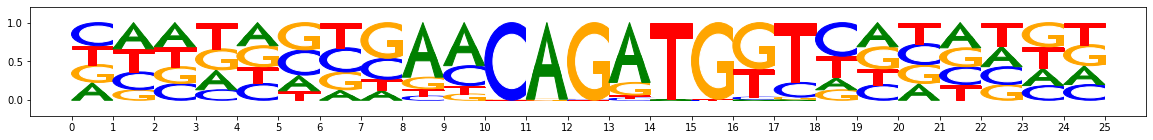

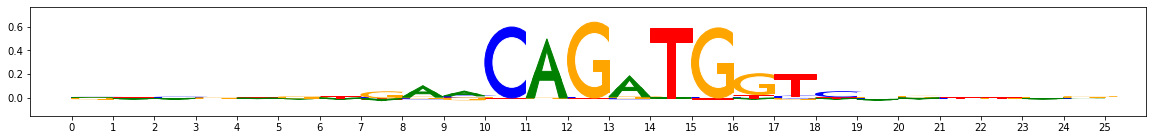

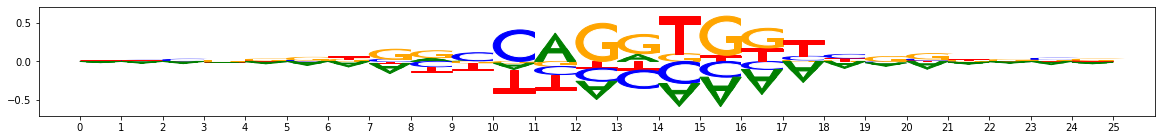

Path to node: root/0/0
Number of seqlets 43


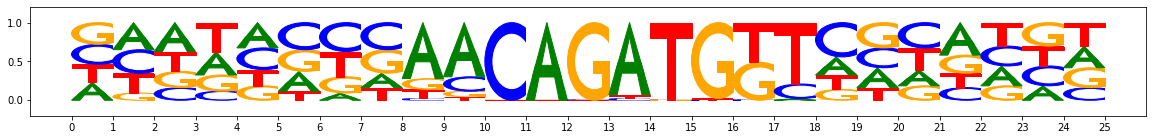

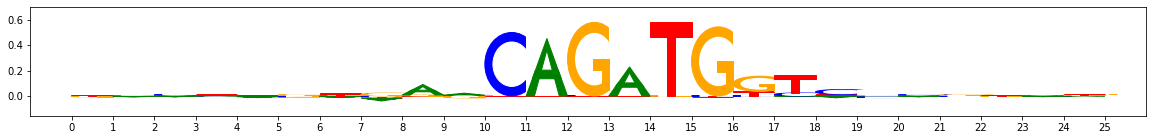

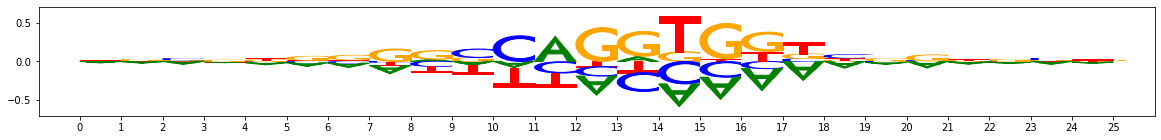

Path to node: root/0/1
Number of seqlets 33


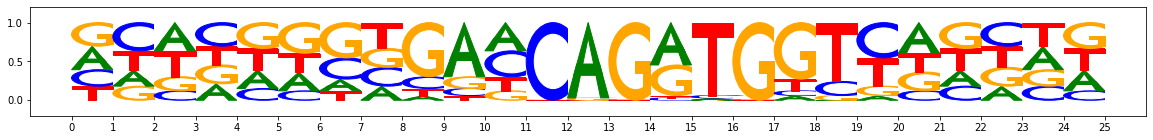

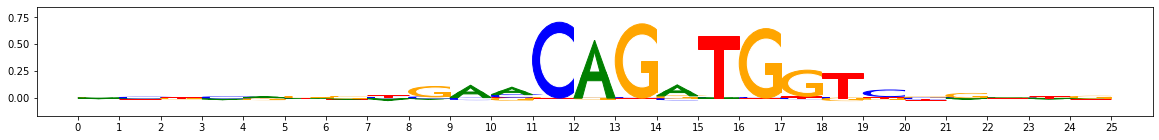

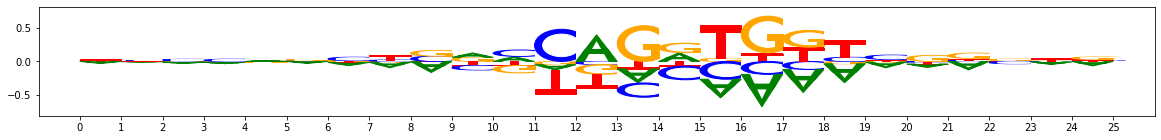

Path to node: root/1
Number of seqlets 72


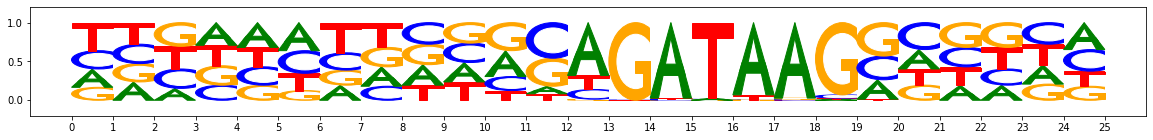

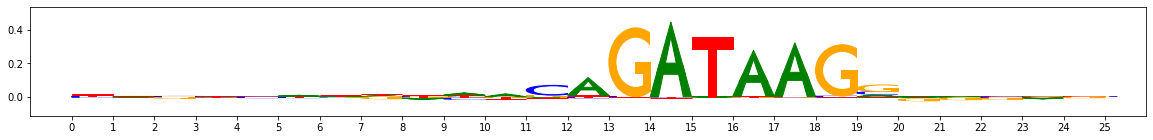

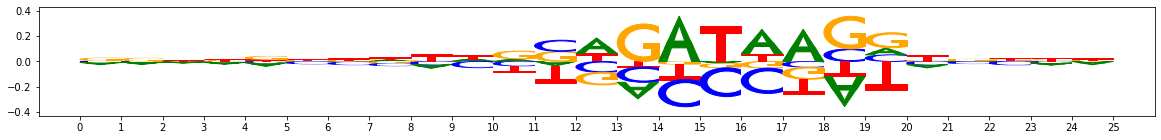

Path to node: root/1/0
Number of seqlets 51


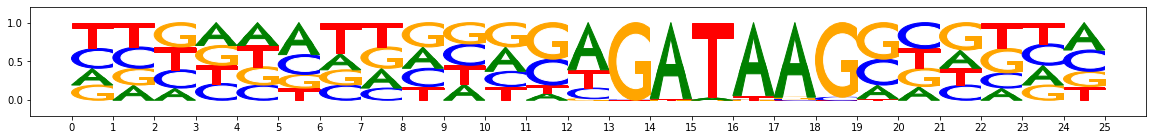

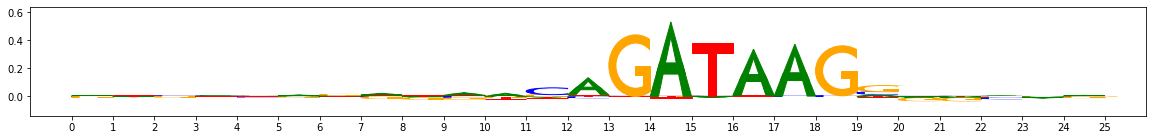

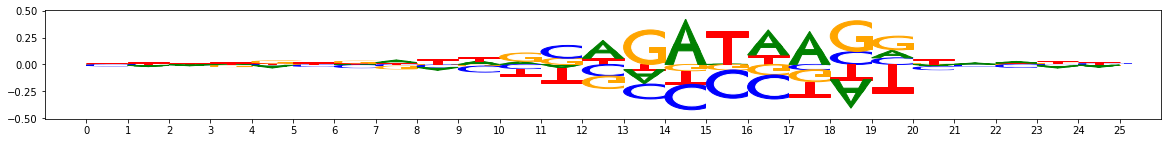

Path to node: root/1/1
Number of seqlets 21


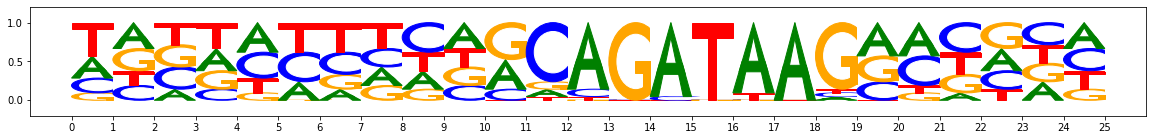

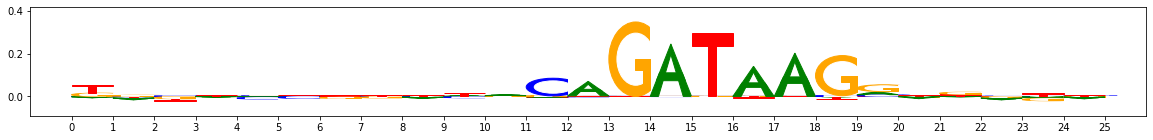

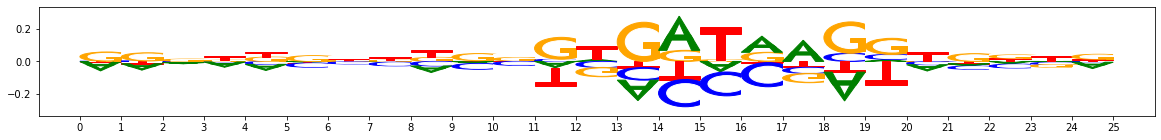

Path to node: root/2
Number of seqlets 3


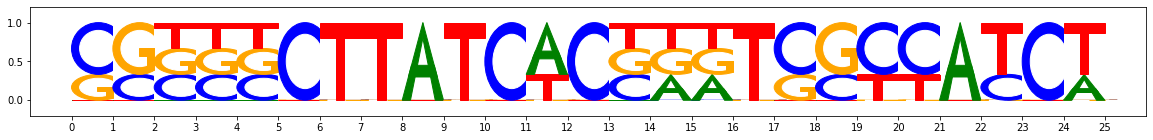

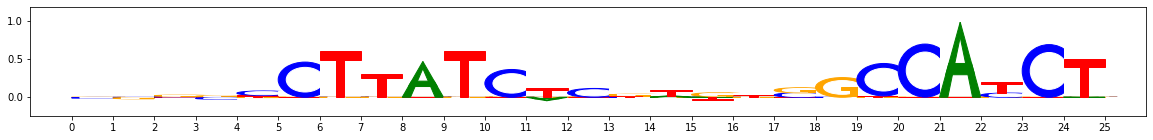

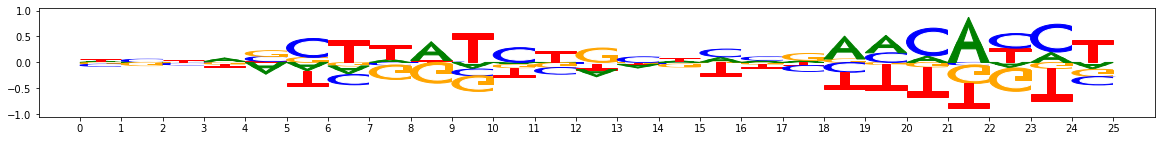

Path to node: root/3
Number of seqlets 1


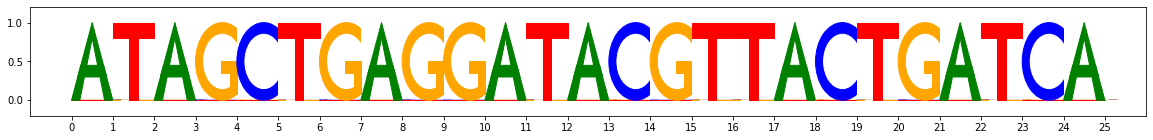

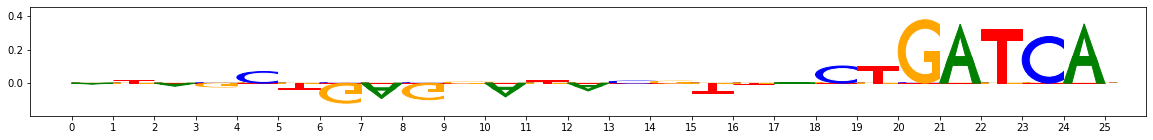

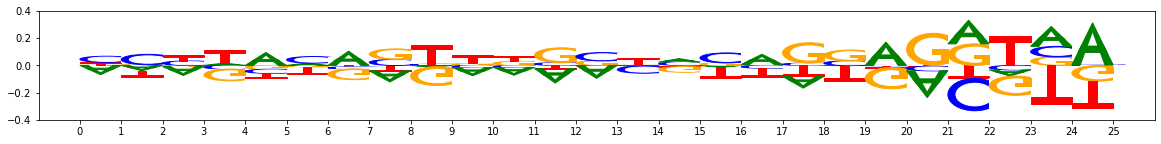

In [17]:
def recursive_plot_hierarchy_motifs(nodes, path):
    for i in range(len(nodes)):
        nodepath = path+"/"+str(i)
        print("Path to node:",nodepath)
        print("Number of seqlets",len(nodes[i].pattern.seqlets))
        if (nodes[i].indices_merged is not None):
            #indices_merged, submat_crosscontam and submat_alignersim can
            # be used to inspect the steps in the merging
            #print("indices merged:",nodes[i].indices_merged)
            #print("submat crosscontam:\n",nodes[i].submat_crosscontam)
            #print("submat alignersim:\n",nodes[i].submat_alignersim)
            pass
        
        #For plotting figures to a png, this code can be used...
        #fig = plt.figure(figsize=(20,5))                                           
        #ax = fig.add_subplot(111)
        #viz_sequence.plot_weights_given_ax(ax, nodes[i].pattern["sequence"].fwd)
        #plt.savefig(nodepath+".png")
        
        viz_sequence.plot_weights(nodes[i].pattern["sequence"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_hypothetical_contribs"].fwd)
        recursive_plot_hierarchy_motifs(nodes[i].child_nodes, path=nodepath)

print("For metacluster 0")
recursive_plot_hierarchy_motifs(loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_0"]
    .seqlets_to_patterns_result.pattern_merge_hierarchy.root_nodes,
    path="root")